In [1]:
import numpy as np
import os
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
import matplotlib.cm as cm
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from collections import Counter
from matplotlib.ticker import FixedLocator
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.preprocessing import MinMaxScaler



In [2]:
full_path = 'C:\\Users\\RJEN0307\\Desktop\\Bachelorprojekt\\Data\\fif files\\epochs_csv\\1_csv'

patient_numbers = []
patient_data = {}

for file in os.listdir(full_path):
    filename = os.fsdecode(file)
    patient_number = filename.split('_')[0] 
    patient_numbers.append(patient_number)
    patient_file_dir = os.path.join(full_path, filename)
    data = pd.read_csv(patient_file_dir)

    data.rename(columns={'Unnamed: 0': 'Index'}, inplace=True)
    data['Event'] = data['Event'].map({'R': 0, 'M': 1, 'F': 2})

    columns_to_remove = [col for col in data.columns if '_N' in col]
    data = data.drop(columns=columns_to_remove)

    resting_data = data[data['Event'] == 0]
    moving_data = data[data['Event'] == 1]
    familiar_data = data[data['Event'] == 2]
    target_count = min(moving_data.shape[0], familiar_data.shape[0])
    resting_data = resting_data.iloc[-target_count:]
    resting_data = resting_data.reset_index(drop=True)
    moving_data = moving_data.reset_index(drop=True)
    familiar_data = familiar_data.reset_index(drop=True)
    balanced_data = pd.concat([resting_data, moving_data, familiar_data]).reset_index(drop=True)

    standarize_list = ['PSD Delta', 'PSD Theta',  'PSD Alpha', 'PSD Beta', 'PSD Gamma', 'PSD SE', 'PSD MSF', 'PSD Sef90', 'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Freq_Slope mean', 'Freq_Slope std']
    
    #standarize_list =  ['PSD Delta', 'PSD Theta', 'PSD Alpha', 'PSD Beta', 'PSD Gamma']

    scaler = StandardScaler()
    balanced_data[standarize_list] = scaler.fit_transform(balanced_data[standarize_list])
    patient_data[patient_number] = balanced_data
    
    # show patient 10
    print(patient_data['p10'].head())

   Index  Event  PSD Delta  PSD Theta  PSD Alpha  PSD Beta  PSD Gamma  \
0   1500      0  -0.504771  -1.555079  -1.113242 -0.866272  -0.493307   
1   1501      0  -1.207551  -1.285578  -0.421632 -0.046604  -0.189003   
2   1502      0   2.094303  -0.218608  -0.972915 -1.282925  -0.468644   
3   1503      0   1.165314  -0.893731   0.395907 -1.449045  -1.025031   
4   1504      0  -0.710573  -0.297616  -1.010877 -0.883369  -1.267831   

     PSD SE   PSD MSF  PSD Sef90  PSD Sef95        PE      wSMI  Kolmogorov  \
0 -0.208458 -0.717660  -0.079449   0.452049 -0.135324 -0.296510    0.232978   
1  0.559548 -0.149165   0.738750   0.735636 -0.360464 -0.265355    0.580077   
2 -1.750320 -1.018849  -1.755760  -1.873936 -2.154975  0.022672   -0.688630   
3 -1.174411 -1.146854  -0.959331  -0.805472 -0.276526 -0.767685   -0.604848   
4  0.104931 -0.145400  -0.161088   0.230050 -0.436271 -0.012307    0.867331   

   Freq_Slope mean  Freq_Slope std  
0        -0.428410        0.710905  
1         1.

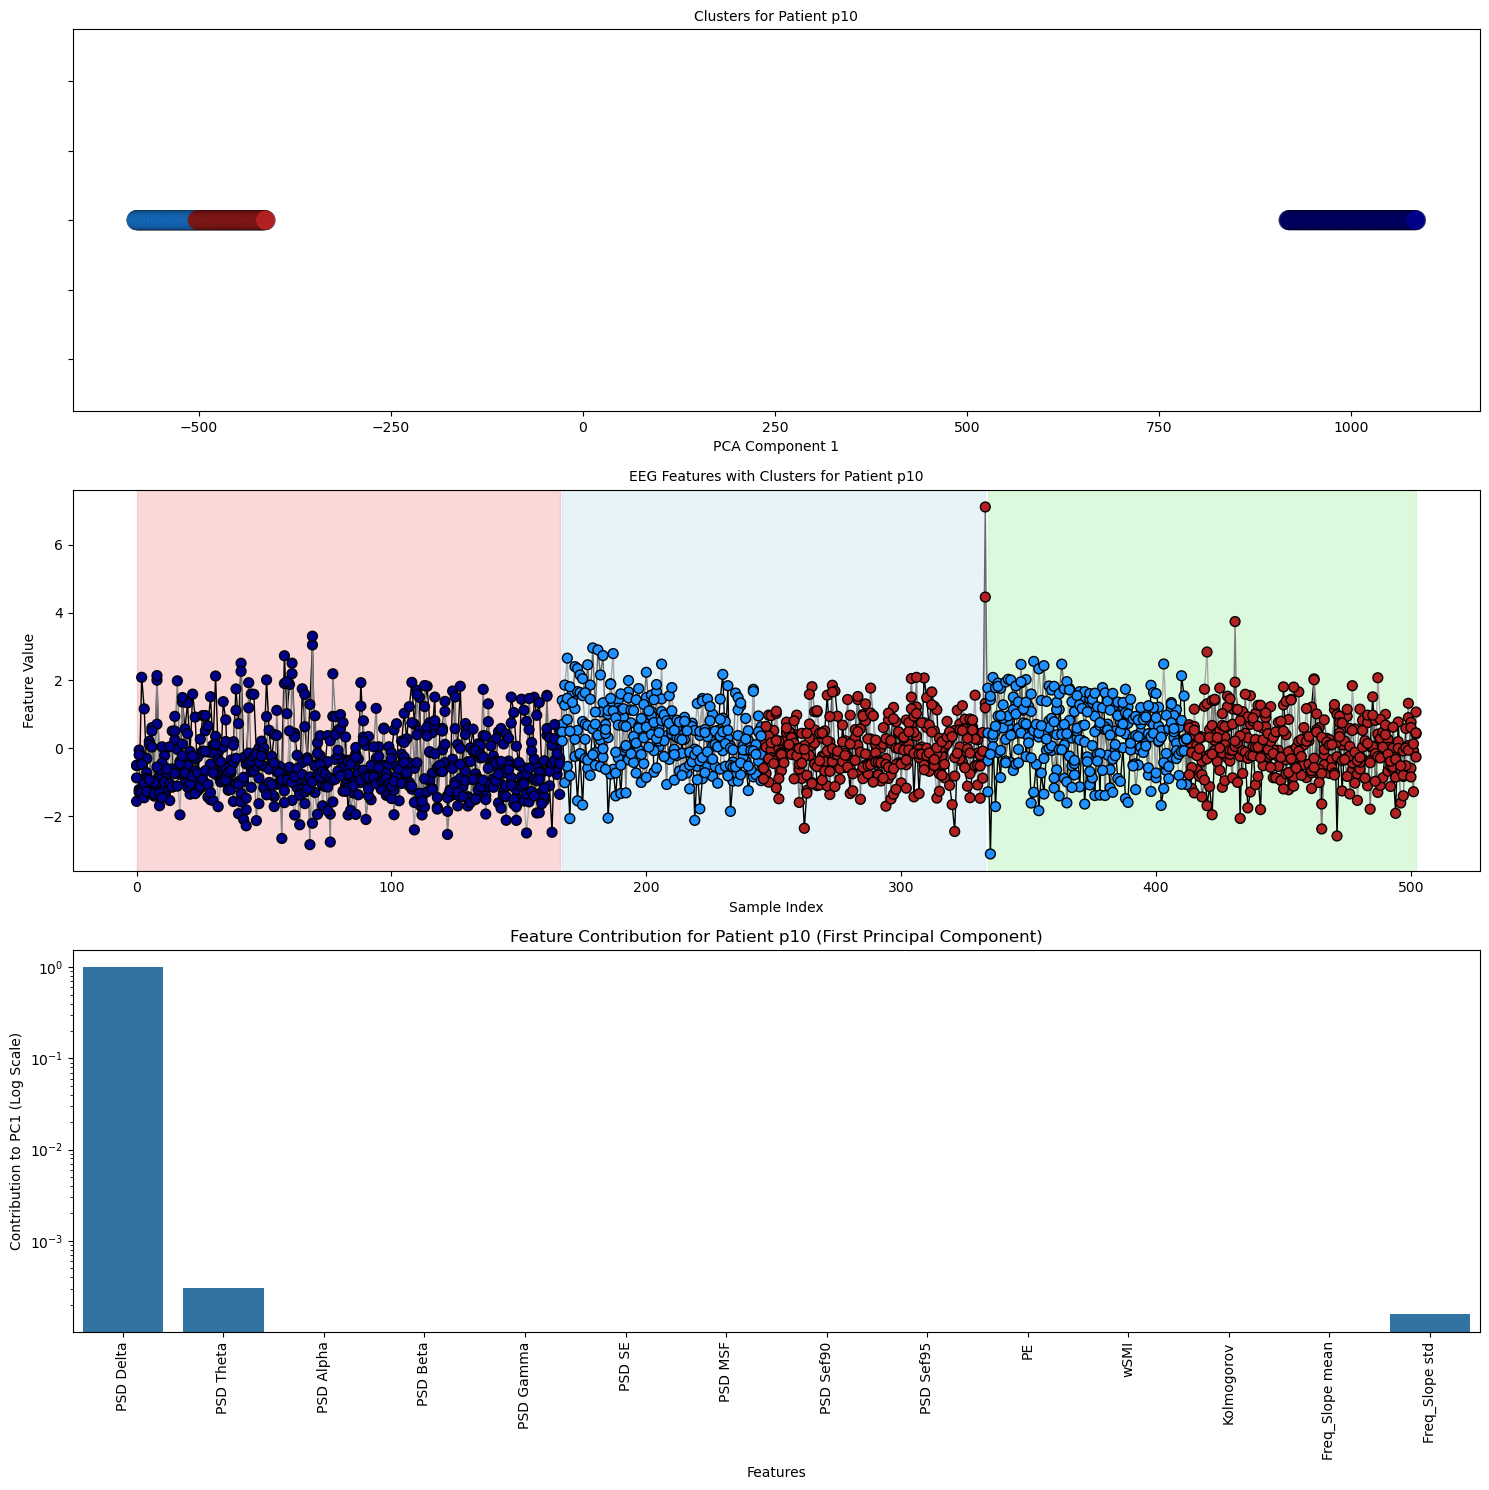

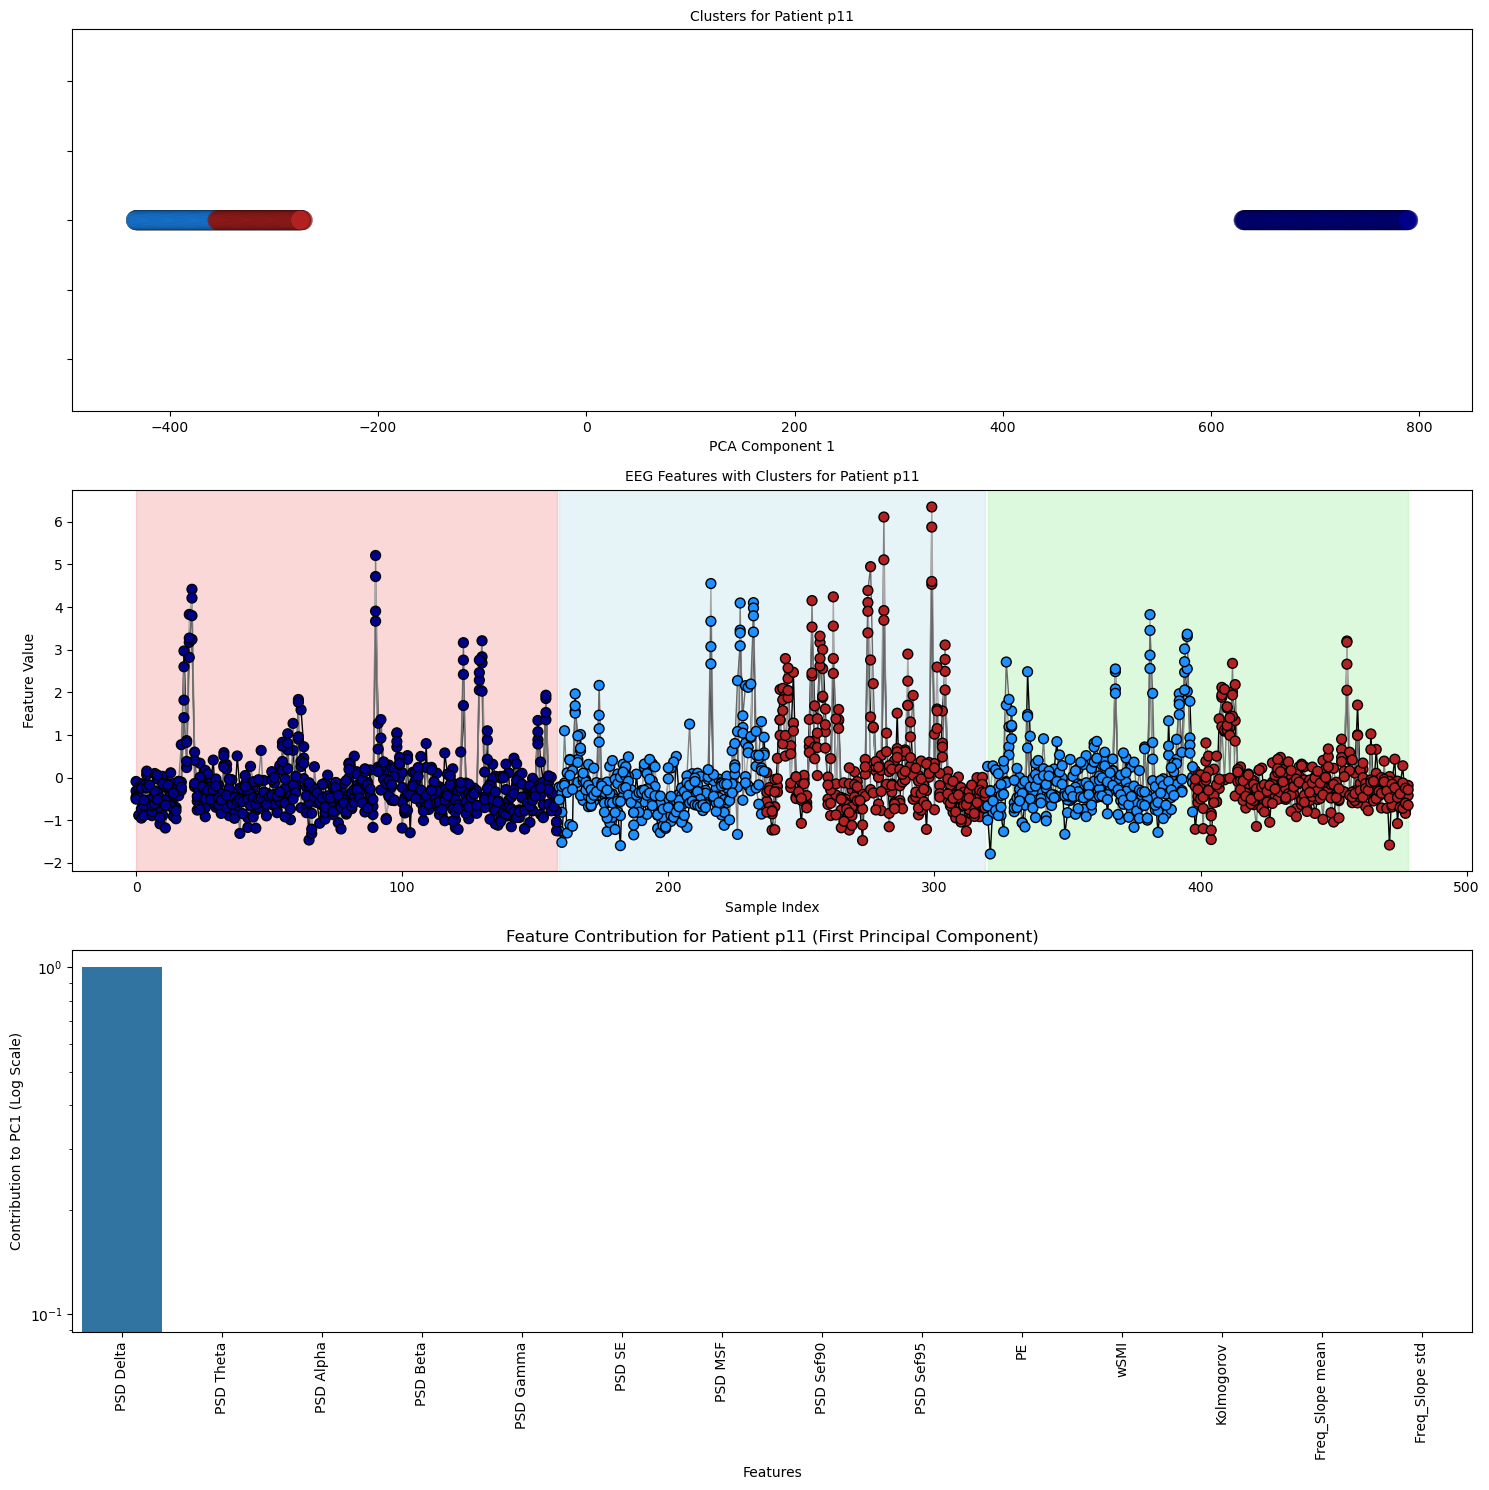

In [85]:
def combined_plot_for_each_patient(patient_data, patients, n_components_pca=5, n_components_gmm=3, save_to_pdf=False, output_pdf_path='combined_patient_plots_final.pdf', contribution_pdf_path='feature_contribution_plot.pdf',output_pca_path = 'PCAplot_1',pca_plot = False,feature_importance=False):
    feature_names = ['PSD Delta', 'PSD Theta', 'PSD Alpha', 'PSD Beta', 'PSD Gamma', 'PSD SE', 'PSD MSF', 'PSD Sef90', 'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Freq_Slope mean', 'Freq_Slope std']
    #feature_names =  ['PSD Delta', 'PSD Theta', 'PSD Alpha', 'PSD Beta', 'PSD Gamma']
    
    if save_to_pdf:
        pdf = PdfPages(output_pdf_path)
    
    feature_importance_count = {feature: 0 for feature in feature_names}
    all_pca_data = []
    all_patient_labels = []

    
    for patient in patients:
        data = patient_data[patient].copy()

        data_for_pca = data.drop(columns=['Event'])

        pca = PCA(n_components=n_components_pca)
        reduced_data = pca.fit_transform(data_for_pca)
        pca_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(n_components_pca)])

        all_pca_data.append(pca_df)
        all_patient_labels.extend([patient] * len(reduced_data))
        
        
        gmm = GaussianMixture(n_components=n_components_gmm, random_state=0)
        gmm.fit(reduced_data)
        labels = gmm.predict(reduced_data)
        
        feature_contributions = np.sum(np.abs(pca.components_[:2]), axis=0)
        feature_contributions /= np.sum(feature_contributions)

        if len(feature_contributions) != len(feature_names):
            feature_contributions = feature_contributions[:len(feature_names)]

        importance_threshold = np.percentile(feature_contributions, 75)

        for idx, contribution in enumerate(feature_contributions):
            if contribution >= importance_threshold:
                feature_importance_count[feature_names[idx]] += 1

        patient_data_with_labels = data.copy()
        patient_data_with_labels['Cluster Label'] = labels

        fig, axes = plt.subplots(3, 1, figsize=(15, 15))
        
        ax = axes[0]
        cluster_colors = ['firebrick' if label == 0 else 'darkblue' if label == 1 else 'dodgerblue' for label in labels]

        scatter = ax.scatter(reduced_data[:, 0], np.zeros_like(reduced_data[:, 0]), 
                            c=cluster_colors, marker='o', edgecolor='black', 
                            linewidth=0.25, s=200, alpha=0.7)  # Removed outline by setting edgecolor='none'
        ax.scatter(gmm.means_[:, 0], np.zeros_like(gmm.means_[:, 0]), s=200, c='black', 
                marker='x', label='Cluster Means', edgecolor='none', linewidth=0)  # No outline for cluster means
        ax.set_title(f"Clusters for Patient {patient}", fontsize=10)
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('')  # No need for y-axis label in 1D
        ax.grid(False)
        ax.set_yticklabels([])  # Hide y-tick labels


        ax2 = axes[1]
        time = np.arange(len(patient_data_with_labels))
        
        ax2.plot(time, patient_data_with_labels['PSD Delta'], label='Delta (0.5-4 Hz)', color='black', linewidth=1)
        ax2.plot(time, patient_data_with_labels['PSD Theta'], label='Theta (4-8 Hz)', color='gray', linewidth=1)
        ax2.plot(time, patient_data_with_labels['PSD Beta'], label='Beta (12-30 Hz)', color='darkgray', linewidth=1)
        ax2.plot(time, patient_data_with_labels['PSD Gamma'], label='Gamma (>30 Hz)', color='dimgray', linewidth=1)

        ax2.scatter(time, patient_data_with_labels['PSD Delta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Delta)', zorder=3)
        ax2.scatter(time, patient_data_with_labels['PSD Theta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Theta)', zorder=3)
        ax2.scatter(time, patient_data_with_labels['PSD Beta'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Beta)', zorder=3)
        ax2.scatter(time, patient_data_with_labels['PSD Gamma'], c=cluster_colors, s=50, edgecolor='black', label='Cluster Data Points (Gamma)', zorder=3)

        stimuli_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen'}  # 0=R, 1=M, 2=F
        
        event_groups = patient_data_with_labels['Event'].ne(patient_data_with_labels['Event'].shift()).cumsum()
        
        for _, group_data in patient_data_with_labels.groupby(event_groups):
            stimulus_value = group_data['Event'].iloc[0]
            if stimulus_value in stimuli_colors:
                start_idx = group_data.index[0]
                end_idx = group_data.index[-1]
                start_time = time[start_idx]
                end_time = time[end_idx]
                ax2.axvspan(start_time, end_time, color=stimuli_colors[stimulus_value], alpha=0.3, zorder=1)
        
        ax2.set_title(f'EEG Features with Clusters for Patient {patient}', fontsize=10)
        ax2.set_xlabel('Sample Index')
        ax2.set_ylabel('Feature Value')
        ax2.grid(False)

        ax3 = axes[2]

        # Extract the feature contributions for the first principal component (PC1)
        pc1_contributions = pca.components_[0]  # First row contains loadings for PC1
        num_features = len(pc1_contributions)  # Number of features in PC1

        # Ensure feature names match the number of contributions in PC1
        adjusted_feature_names = feature_names[:num_features]

        # Calculate the minimum length to ensure compatibility
        min_length = min(len(adjusted_feature_names), len(pc1_contributions))

        # Plot the contributions with a log scale on the y-axis
        sns.barplot(x=adjusted_feature_names[:min_length], y=pc1_contributions[:min_length], ax=ax3, legend=False)
        ax3.set_yscale('log')  # Set y-axis to log scale
        ax3.set_xticklabels(adjusted_feature_names[:min_length], rotation=90)
        ax3.set_xlabel('Features')
        ax3.set_ylabel('Contribution to PC1 (Log Scale)')
        ax3.set_title(f'Feature Contribution for Patient {patient} (First Principal Component)')

        plt.tight_layout()


        plt.tight_layout()
        
        if save_to_pdf:
            pdf.savefig(fig)
            plt.close(fig)
        else:
            plt.show()

    if save_to_pdf:
        pdf.close()

    if feature_importance:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(feature_importance_count.keys()), y=list(feature_importance_count.values()), palette='viridis', hue=list(feature_importance_count.keys()), legend=False)

        plt.xlabel('Features')
        plt.ylabel('Count of Importance')
        plt.title('Feature Importance Count Across All Patients')
        plt.xticks(rotation=90)
        plt.tight_layout()

        if save_to_pdf:
            plt.savefig(contribution_pdf_path)
            plt.close()
        else:
            plt.show()
    else:
        plt.show()

    if pca_plot:
        combined_pca_df = pd.concat(all_pca_data, ignore_index=True)
        combined_pca_df['Patient'] = all_patient_labels
        pair_plot = sns.pairplot(combined_pca_df, hue='Patient', height=1.5, aspect=1, plot_kws={'s': 10}, diag_kind='hist')
        pair_plot._legend.remove()
        plt.suptitle("Combined PCA Pair Plot for All Patients", y=1.02)

        pca_image_path = output_pca_path.replace('.pdf', '_temp.png')
        pair_plot.savefig(pca_image_path, dpi=300, bbox_inches='tight')
        plt.show() 
        plt.close()

        if save_to_pdf:
            with PdfPages(output_pca_path) as pdf:
                img = plt.imread(pca_image_path)
                img_height, img_width = img.shape[0:2]
                fig, ax = plt.subplots(figsize=(img_width / 100, img_height / 100)) 
                ax.imshow(img)
                ax.axis('off') 
                pdf.savefig(fig, bbox_inches='tight') 
                plt.close(fig)

        if os.path.exists(pca_image_path):
            os.remove(pca_image_path)


patients = ['p10','p11']

# Example
combined_plot_for_each_patient(patient_data, patients, n_components_pca=1, n_components_gmm=3, feature_importance=False, pca_plot=False)

# Render and export all
#combined_plot_for_each_patient(patient_data, patients, n_components_pca=8, n_components_gmm=3, save_to_pdf=True, feature_importance=True, pca_plot=True, output_pdf_path='PDF files\\All features\\Patientplots_1.pdf', contribution_pdf_path='PDF files\\All features\\Featureplots_1.pdf',output_pca_path = 'PDF files\\All features\\PCAplots_1.pdf')


In [86]:
pca = PCA(n_components=2)
data = patient_data['p10'].copy()
data_for_pca = data.drop(columns=['Event'])
reduced_data = pca.fit_transform(data_for_pca)

feature_contributions = np.sum(np.abs(pca.components_), axis=0)
feature_contributions /= np.sum(feature_contributions)
print(feature_contributions)

np.abs(pca.components_[0])

[0.23965186 0.087092   0.01102745 0.05431217 0.0417287  0.00804812
 0.09179404 0.08685315 0.09145772 0.08685817 0.08138255 0.03428
 0.07209474 0.00483897 0.00858037]


array([9.99997593e-01, 3.04482853e-04, 3.71215138e-04, 7.42729079e-04,
       8.65523738e-04, 8.82936229e-04, 6.47203868e-04, 5.84697240e-04,
       6.51068346e-04, 6.45584870e-04, 6.45320432e-04, 3.13776242e-04,
       5.99603726e-04, 1.56731139e-04, 5.07700598e-05])

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def classification_for_patients(patient_data, patients, n_components_pca=1, n_components_gmm=3, save_to_pdf=False, output_pdf_path='combined_patient_plots_final.pdf'):
    feature_names = ['PSD Delta', 'PSD Theta', 'PSD Alpha', 'PSD Beta', 'PSD Gamma', 'PSD SE', 'PSD MSF', 'PSD Sef90', 'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Freq_Slope mean', 'Freq_Slope std']
    
    if save_to_pdf:
        pdf = PdfPages(output_pdf_path)
    
    for patient in patients:
        data = patient_data[patient].copy()

        # Prepare PCA data
        data_for_pca = data.drop(columns=['Event'])
        pca = PCA(n_components=n_components_pca)
        reduced_data = pca.fit_transform(data_for_pca)
        pca_df = pd.DataFrame(reduced_data, columns=[f'PC{i+1}' for i in range(n_components_pca)])

        # Define the events as resting or combined familiar/medical
        labels = data['Event'].apply(lambda x: 1 if x in [1, 2] else 0).values  # Familiar/Medical as 1, Resting as 0

        # Calculate threshold as the midpoint between the means of two classes on PC1
        pc1_data = reduced_data[:, 0]  # Only the first principal component
        threshold = (pc1_data[labels == 0].mean() + pc1_data[labels == 1].mean()) / 2

        # Predict using the threshold for visual comparison
        predicted_labels = (pc1_data < threshold).astype(int)

        # Evaluate and print the performance
        print(f"Accuracy for Patient {patient}:", accuracy_score(labels, predicted_labels))
        print("Classification Report:")
        print(classification_report(labels, predicted_labels))
        print("Confusion Matrix:")
        print(confusion_matrix(labels, predicted_labels))

        # Plot PCA component 1 with threshold
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.scatter(pc1_data[labels == 0], np.zeros_like(pc1_data[labels == 0]), color='blue', label='Resting')
        ax.scatter(pc1_data[labels == 1], np.zeros_like(pc1_data[labels == 1]), color='red', label='Familiar/Medical')
        ax.axvline(x=threshold, color='green', linestyle='--', label='Threshold')
        ax.set_title(f"Separation of Resting and Familiar/Medical States for Patient {patient}")
        ax.set_xlabel('PCA Component 1')
        ax.legend()

        if save_to_pdf:
            pdf.savefig(fig)
            plt.close(fig)
        else:
            plt.show()

    if save_to_pdf:
        pdf.close()

# Example usage for all patients
patients = patient_data.keys()
classification_for_patients(patient_data, patients, n_components_pca=1)


In [20]:
from collections import Counter

# Check the balance in the training labels
print("Training set class distribution:", Counter(y_train))
print("Testing set class distribution:", Counter(y_test))


Training set class distribution: Counter({1: 17941, 0: 8345})
Testing set class distribution: Counter({1: 7769, 0: 3497})


Fold Confusion Matrix for Patient p10:
[[35  0]
 [ 0 66]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        66

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101

Fold Confusion Matrix for Patient p10:
[[40  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        61

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101

Fold Confusion Matrix for Patient p10:
[[27  0]
 [ 0 74]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

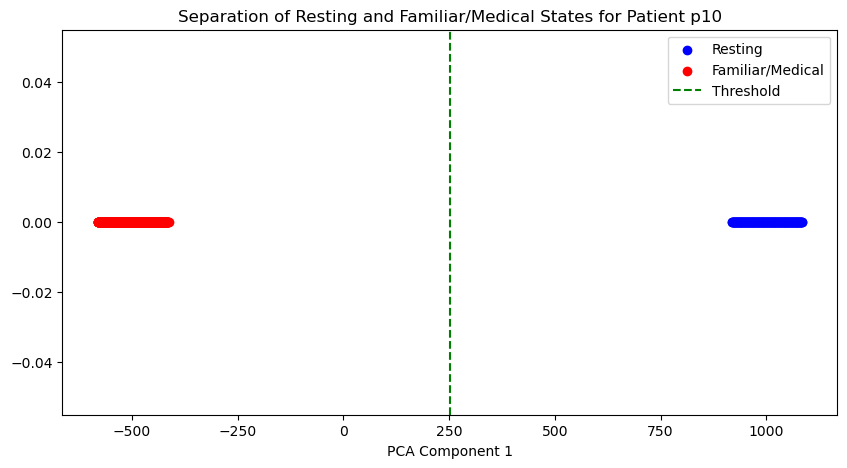

Fold Confusion Matrix for Patient p11:
[[35  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        61

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Fold Confusion Matrix for Patient p11:
[[37  0]
 [ 0 59]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        59

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Fold Confusion Matrix for Patient p11:
[[28  0]
 [ 0 68]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

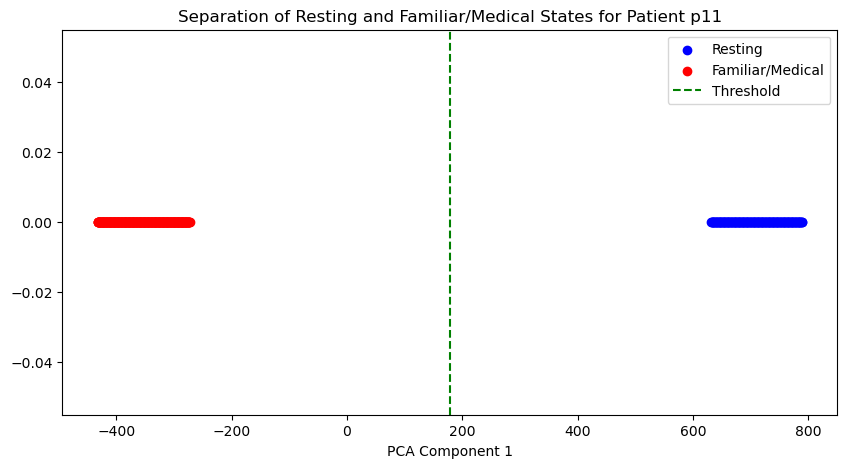

Fold Confusion Matrix for Patient p12:
[[35  0]
 [ 0 60]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        60

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

Fold Confusion Matrix for Patient p12:
[[33  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        62

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

Fold Confusion Matrix for Patient p12:
[[28  0]
 [ 0 67]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

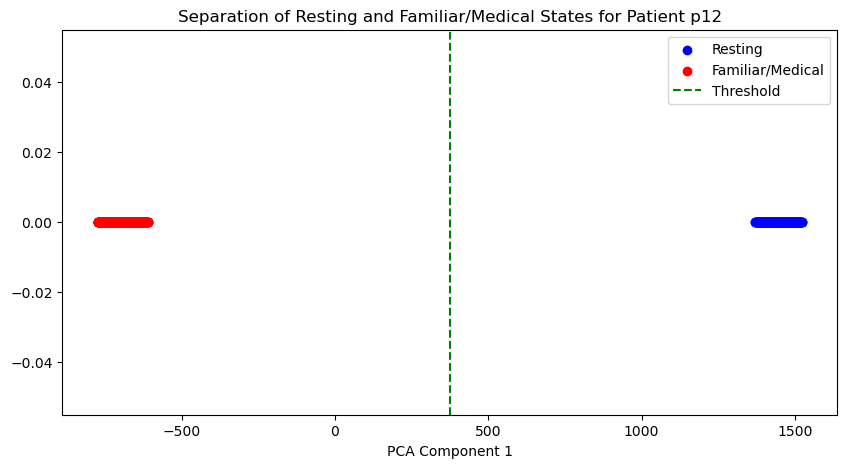

Fold Confusion Matrix for Patient p13:
[[32  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        63

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

Fold Confusion Matrix for Patient p13:
[[33  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        62

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

Fold Confusion Matrix for Patient p13:
[[28  0]
 [ 0 66]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

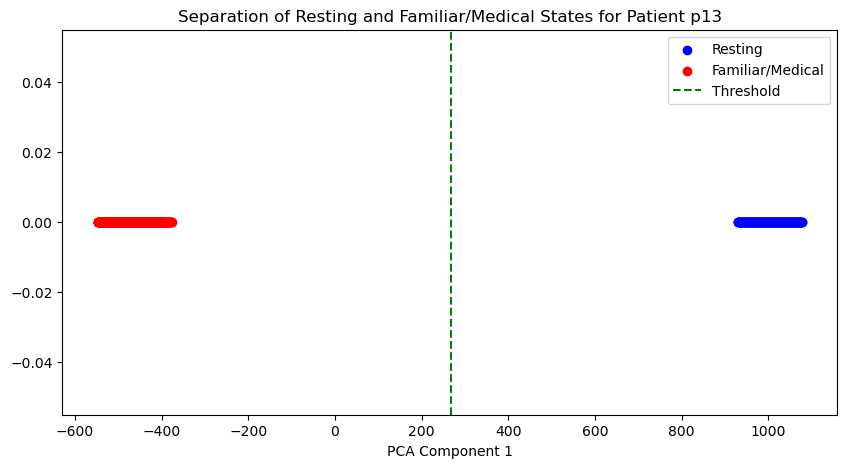

Fold Confusion Matrix for Patient p14:
[[34  0]
 [ 0 59]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        59

    accuracy                           1.00        93
   macro avg       1.00      1.00      1.00        93
weighted avg       1.00      1.00      1.00        93

Fold Confusion Matrix for Patient p14:
[[30  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        63

    accuracy                           1.00        93
   macro avg       1.00      1.00      1.00        93
weighted avg       1.00      1.00      1.00        93

Fold Confusion Matrix for Patient p14:
[[26  0]
 [ 0 67]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

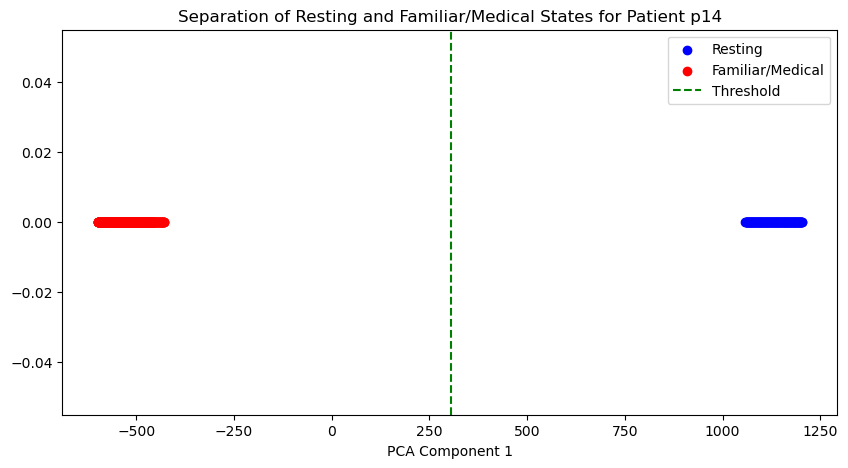

Fold Confusion Matrix for Patient p15:
[[35  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        63

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98

Fold Confusion Matrix for Patient p15:
[[37  0]
 [ 0 60]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        60

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p15:
[[25  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

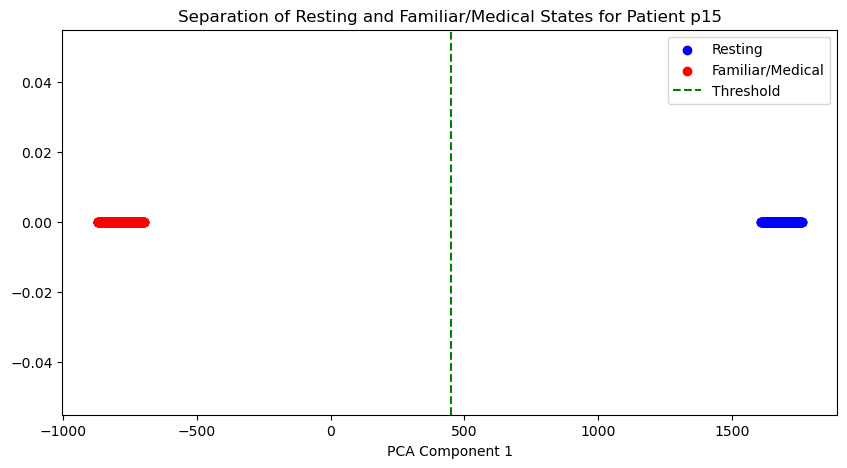

Fold Confusion Matrix for Patient p16:
[[34  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        61

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

Fold Confusion Matrix for Patient p16:
[[34  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        61

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

Fold Confusion Matrix for Patient p16:
[[29  0]
 [ 0 66]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

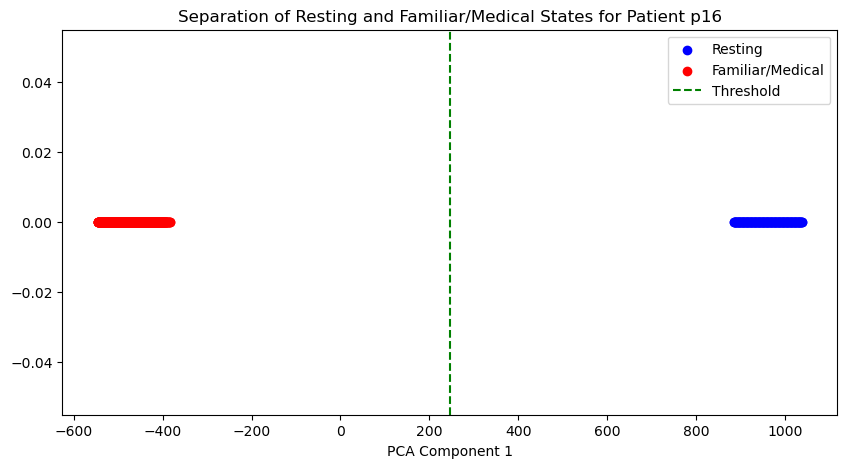

Fold Confusion Matrix for Patient p17:
[[35  0]
 [ 0 66]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        66

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101

Fold Confusion Matrix for Patient p17:
[[40  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        61

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101

Fold Confusion Matrix for Patient p17:
[[25  0]
 [ 0 76]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

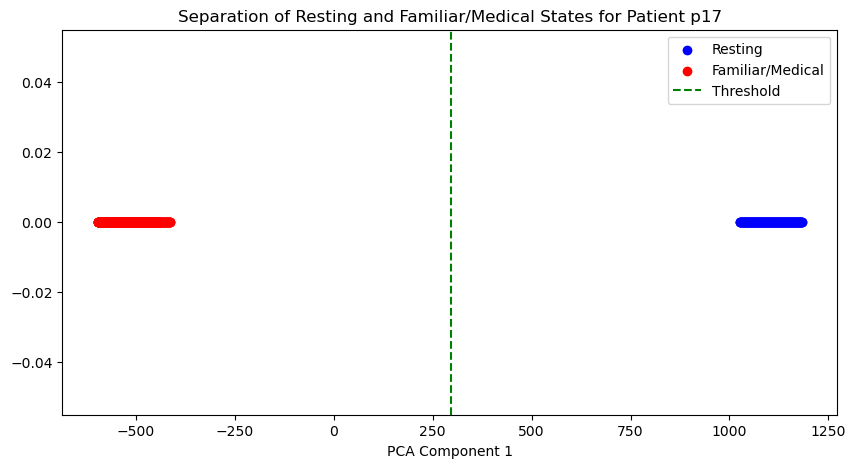

Fold Confusion Matrix for Patient p18:
[[33  0]
 [ 0 66]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        66

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99

Fold Confusion Matrix for Patient p18:
[[36  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        63

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99

Fold Confusion Matrix for Patient p18:
[[25  0]
 [ 0 73]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

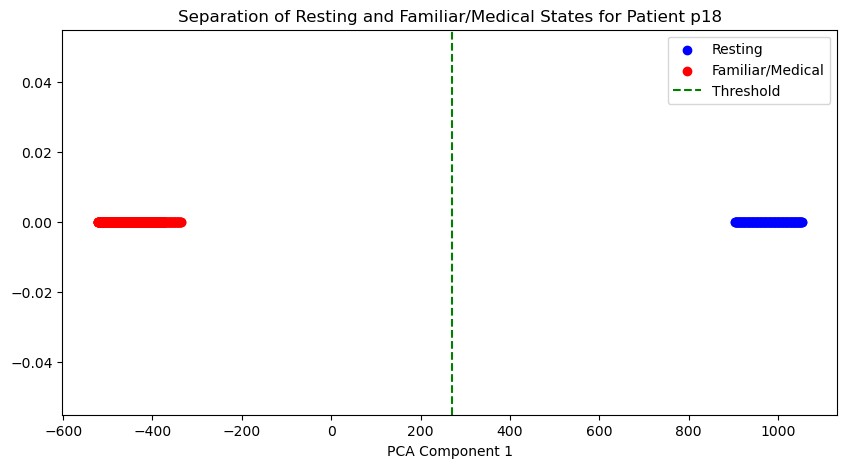

Fold Confusion Matrix for Patient p19:
[[36  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        61

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p19:
[[35  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        62

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p19:
[[25  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

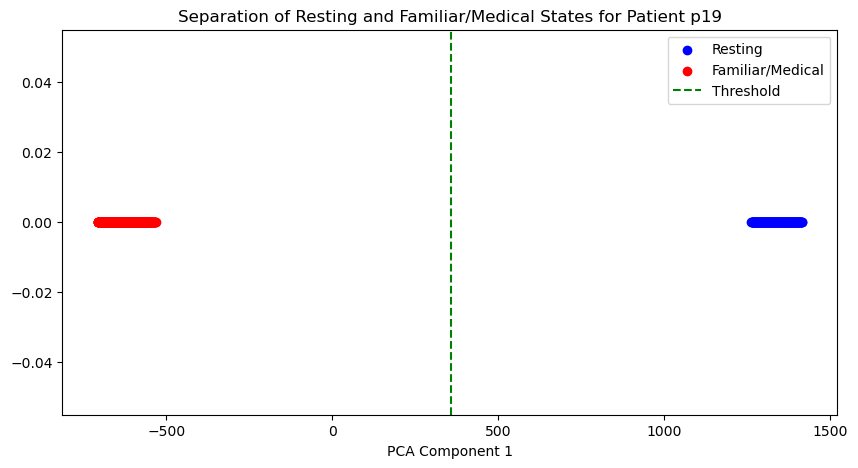

Fold Confusion Matrix for Patient p20:
[[34  0]
 [ 0 68]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        68

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102

Fold Confusion Matrix for Patient p20:
[[38  0]
 [ 0 64]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        64

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102

Fold Confusion Matrix for Patient p20:
[[30  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

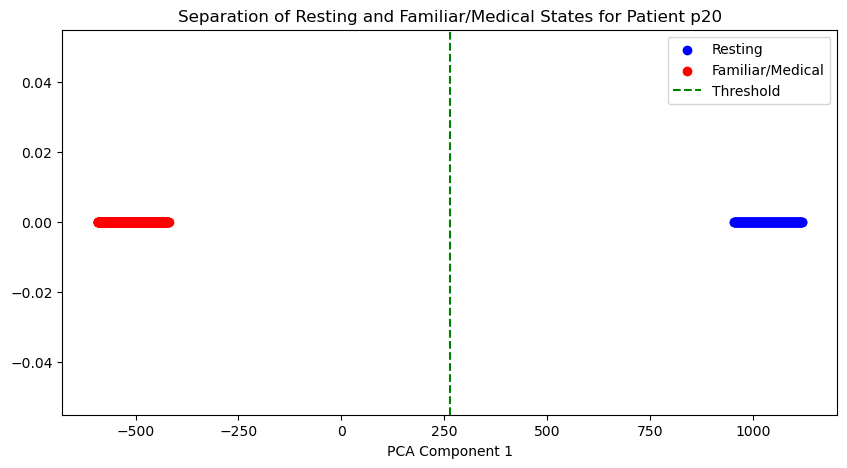

Fold Confusion Matrix for Patient p21:
[[35  0]
 [ 0 58]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        58

    accuracy                           1.00        93
   macro avg       1.00      1.00      1.00        93
weighted avg       1.00      1.00      1.00        93

Fold Confusion Matrix for Patient p21:
[[30  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        63

    accuracy                           1.00        93
   macro avg       1.00      1.00      1.00        93
weighted avg       1.00      1.00      1.00        93

Fold Confusion Matrix for Patient p21:
[[29  0]
 [ 0 64]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

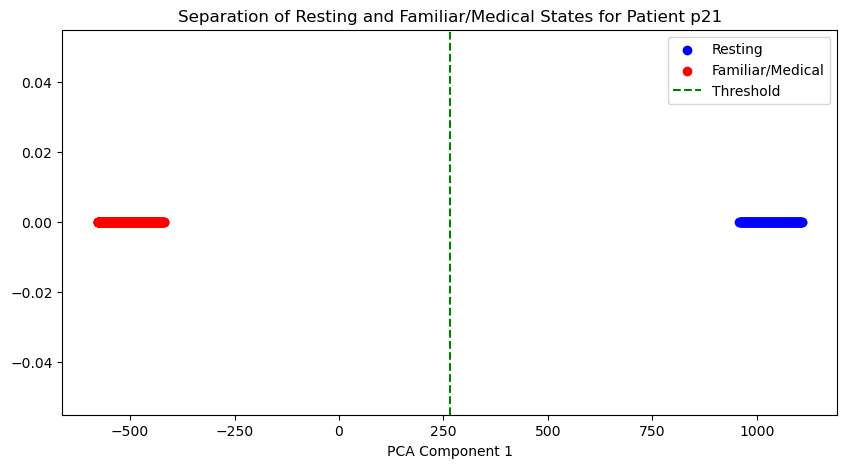

Fold Confusion Matrix for Patient p22:
[[31  0]
 [ 0 65]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        65

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Fold Confusion Matrix for Patient p22:
[[36  0]
 [ 0 59]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        59

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

Fold Confusion Matrix for Patient p22:
[[28  0]
 [ 0 67]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

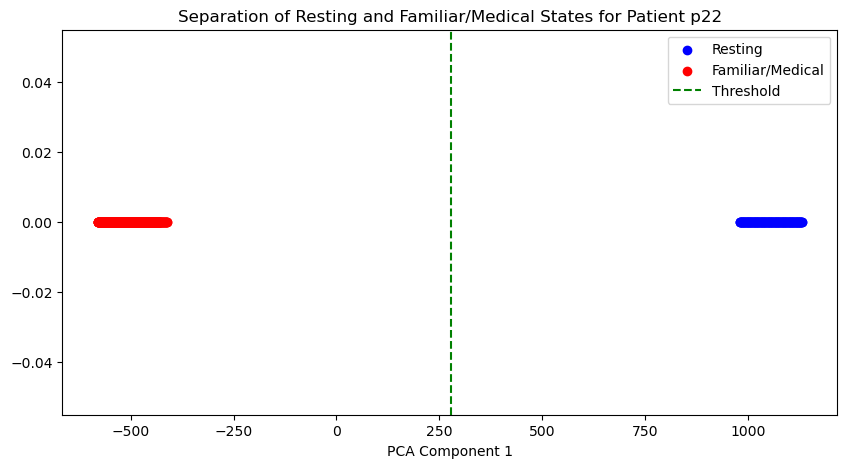

Fold Confusion Matrix for Patient p23:
[[35  0]
 [ 0 66]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        66

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101

Fold Confusion Matrix for Patient p23:
[[40  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        61

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101

Fold Confusion Matrix for Patient p23:
[[25  0]
 [ 0 75]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

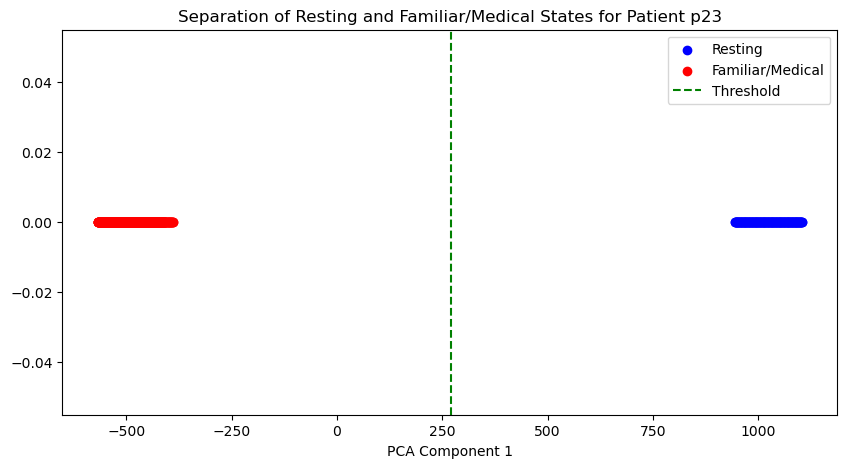

Fold Confusion Matrix for Patient p24:
[[34  0]
 [ 0 68]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        68

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102

Fold Confusion Matrix for Patient p24:
[[38  0]
 [ 0 64]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        64

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102

Fold Confusion Matrix for Patient p24:
[[30  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

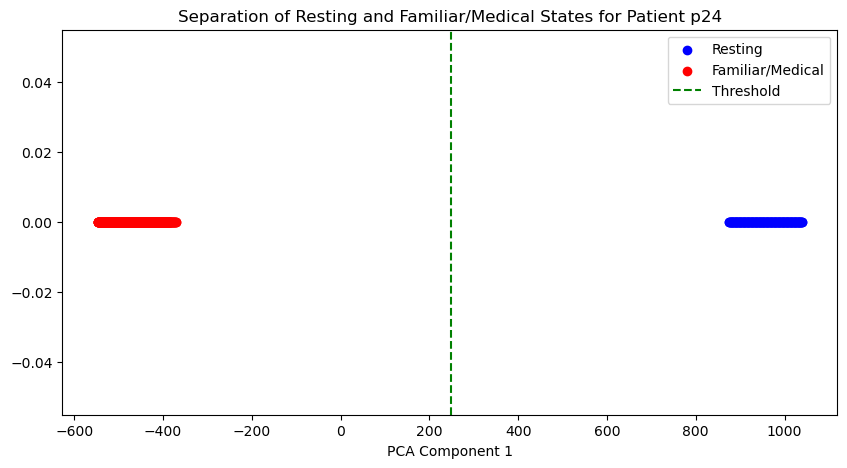

Fold Confusion Matrix for Patient p25:
[[34  0]
 [ 0 68]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        68

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102

Fold Confusion Matrix for Patient p25:
[[38  0]
 [ 0 64]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        64

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102

Fold Confusion Matrix for Patient p25:
[[28  0]
 [ 0 74]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

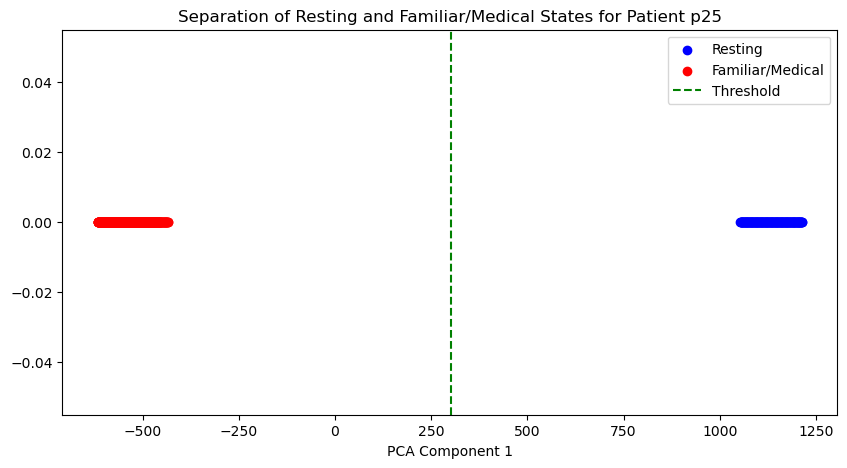

Fold Confusion Matrix for Patient p27:
[[36  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        61

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p27:
[[37  0]
 [ 0 60]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        60

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p27:
[[25  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

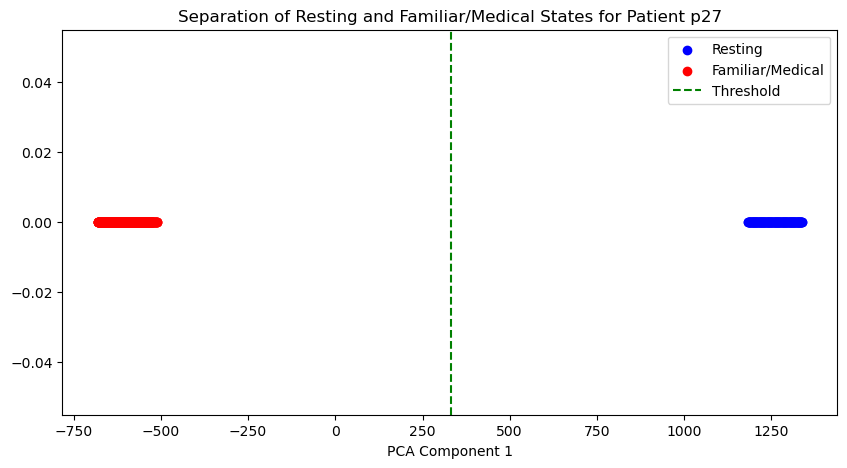

Fold Confusion Matrix for Patient p28:
[[36  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        61

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p28:
[[37  0]
 [ 0 60]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        60

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p28:
[[25  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

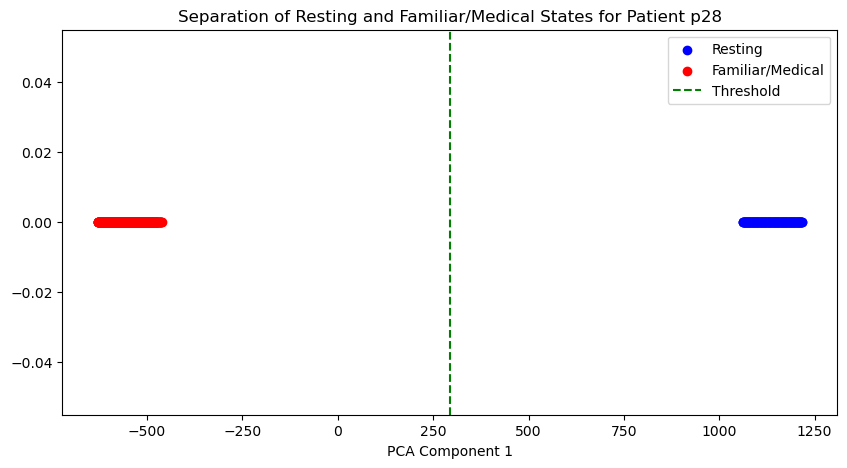

Fold Confusion Matrix for Patient p29:
[[36  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        63

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99

Fold Confusion Matrix for Patient p29:
[[38  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        61

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99

Fold Confusion Matrix for Patient p29:
[[26  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

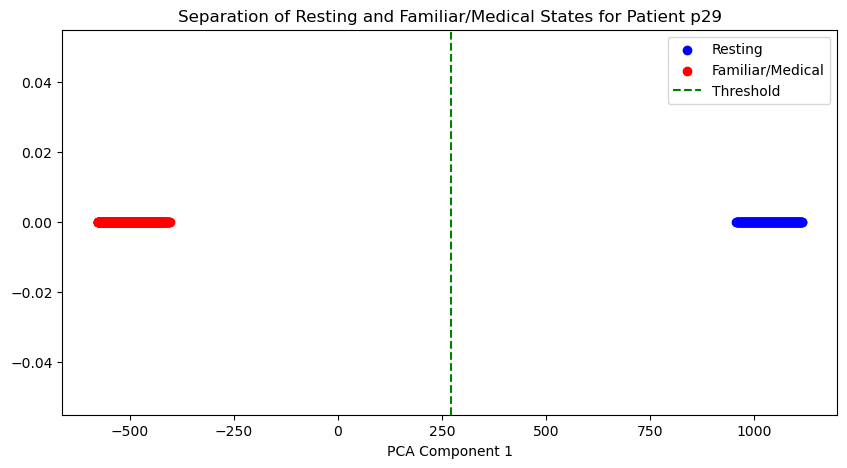

Fold Confusion Matrix for Patient p2:
[[33  0]
 [ 0 65]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        65

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98

Fold Confusion Matrix for Patient p2:
[[35  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        62

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p2:
[[23  0]
 [ 0 74]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00   

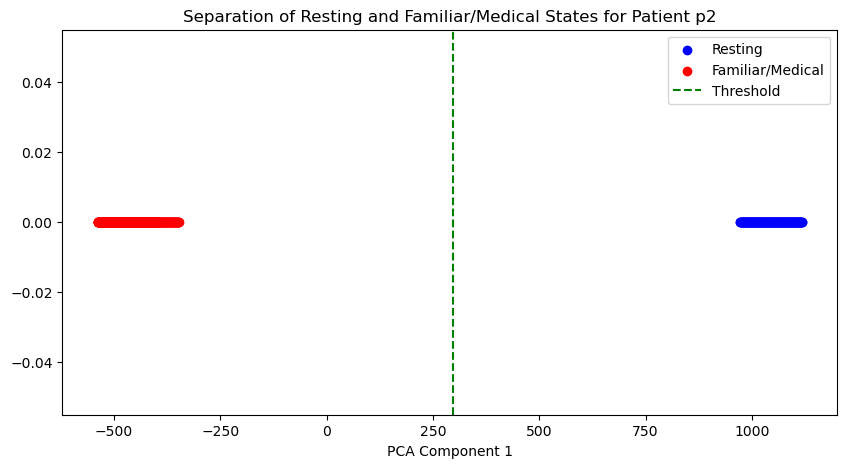

Fold Confusion Matrix for Patient p30:
[[35  0]
 [ 0 65]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        65

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Fold Confusion Matrix for Patient p30:
[[40  0]
 [ 0 60]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        60

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Fold Confusion Matrix for Patient p30:
[[25  0]
 [ 0 75]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

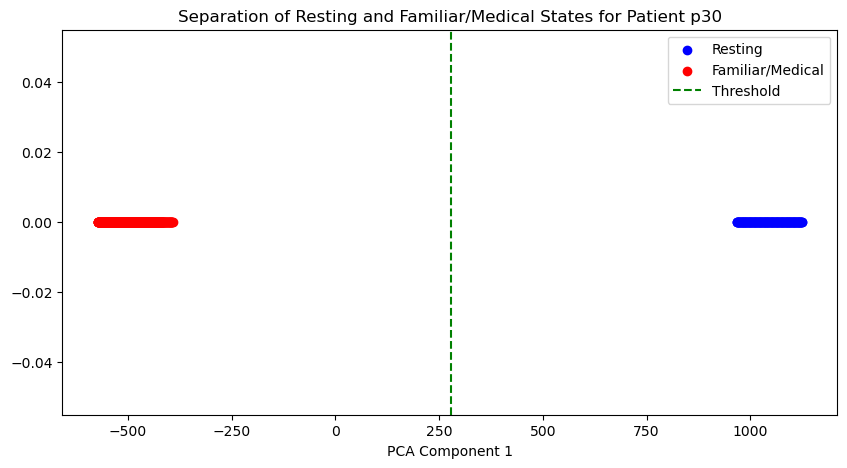

Fold Confusion Matrix for Patient p31:
[[34  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        62

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Fold Confusion Matrix for Patient p31:
[[36  0]
 [ 0 60]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        60

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Fold Confusion Matrix for Patient p31:
[[27  0]
 [ 0 69]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

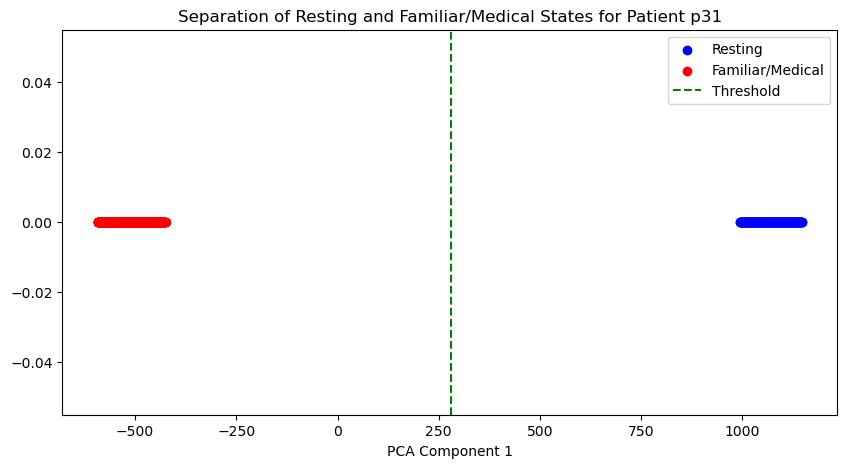

Fold Confusion Matrix for Patient p32:
[[35  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        62

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p32:
[[34  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        63

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p32:
[[24  0]
 [ 0 73]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

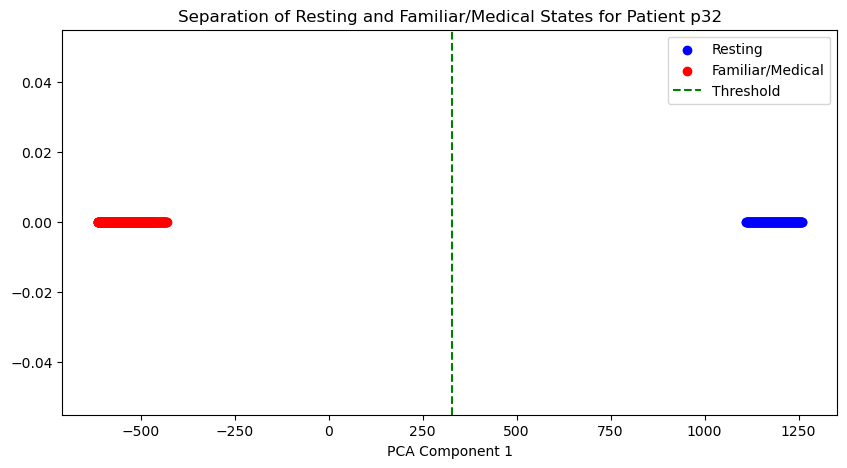

Fold Confusion Matrix for Patient p33:
[[38  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        62

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Fold Confusion Matrix for Patient p33:
[[38  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        61

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99

Fold Confusion Matrix for Patient p33:
[[25  0]
 [ 0 74]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

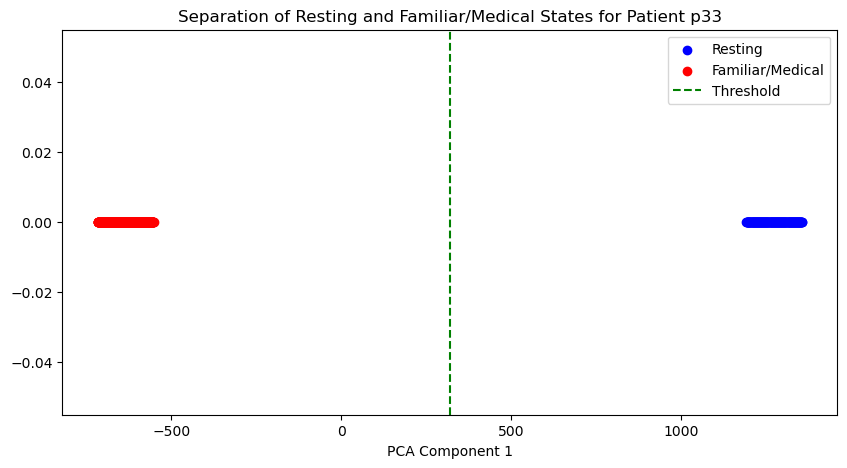

Fold Confusion Matrix for Patient p34:
[[35  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        62

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p34:
[[35  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        62

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p34:
[[25  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

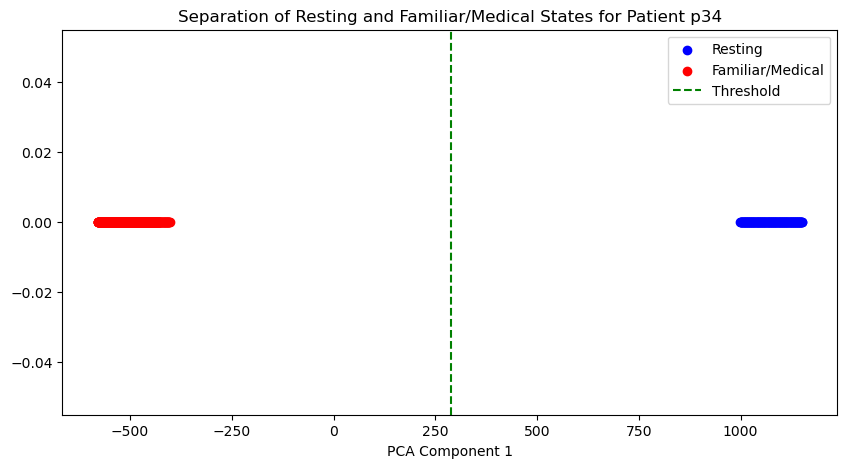

Fold Confusion Matrix for Patient p35:
[[35  0]
 [ 0 65]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        65

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Fold Confusion Matrix for Patient p35:
[[40  0]
 [ 0 60]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        60

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Fold Confusion Matrix for Patient p35:
[[24  0]
 [ 0 76]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

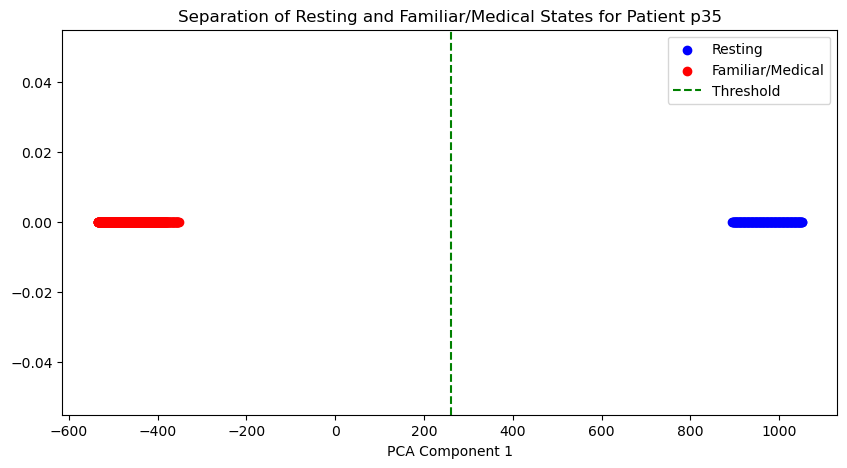

Fold Confusion Matrix for Patient p36:
[[46  0]
 [ 0 85]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        85

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131

Fold Confusion Matrix for Patient p36:
[[43  0]
 [ 0 88]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        88

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131

Fold Confusion Matrix for Patient p36:
[[42  0]
 [ 0 89]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

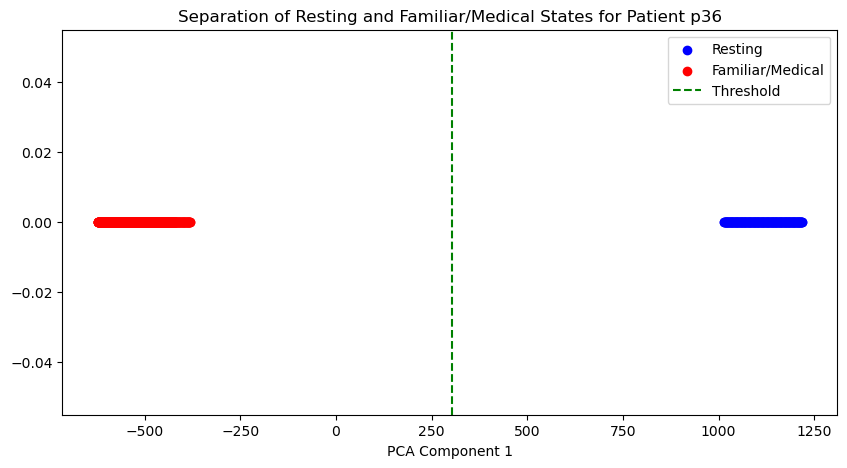

Fold Confusion Matrix for Patient p37:
[[35  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        63

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98

Fold Confusion Matrix for Patient p37:
[[37  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        61

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98

Fold Confusion Matrix for Patient p37:
[[25  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

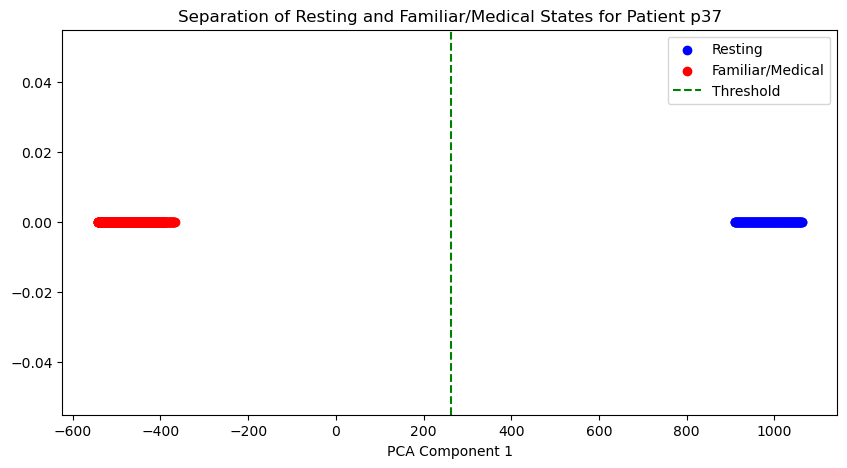

Fold Confusion Matrix for Patient p38:
[[34  0]
 [ 0 67]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        67

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101

Fold Confusion Matrix for Patient p38:
[[41  0]
 [ 0 60]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        60

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101

Fold Confusion Matrix for Patient p38:
[[25  0]
 [ 0 76]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

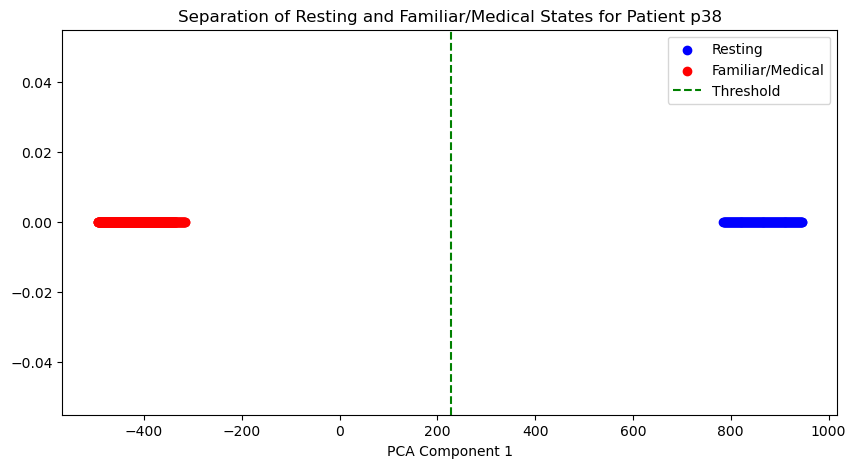

Fold Confusion Matrix for Patient p39:
[[42  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       1.00      1.00      1.00        63

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105

Fold Confusion Matrix for Patient p39:
[[34  0]
 [ 0 71]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        71

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105

Fold Confusion Matrix for Patient p39:
[[28  0]
 [ 0 77]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

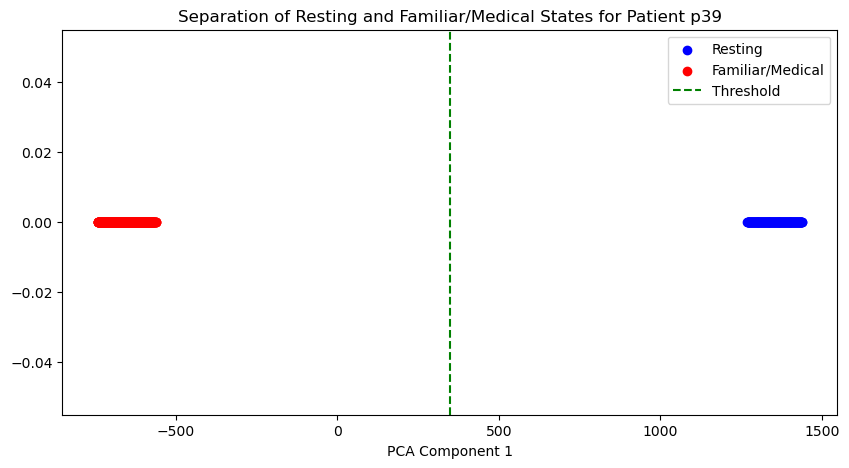

Fold Confusion Matrix for Patient p3:
[[34  0]
 [ 0 68]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        68

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102

Fold Confusion Matrix for Patient p3:
[[38  0]
 [ 0 64]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        64

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102

Fold Confusion Matrix for Patient p3:
[[30  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00   

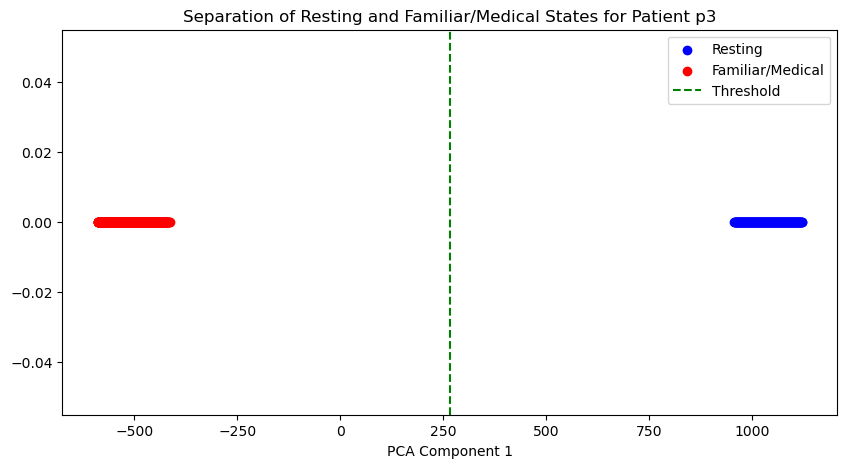

Fold Confusion Matrix for Patient p40:
[[33  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        61

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94

Fold Confusion Matrix for Patient p40:
[[31  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        63

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94

Fold Confusion Matrix for Patient p40:
[[28  0]
 [ 0 66]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

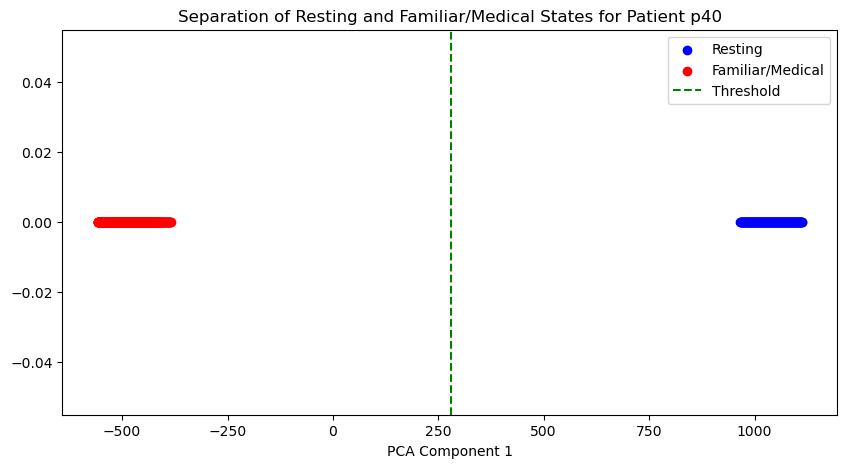

Fold Confusion Matrix for Patient p41:
[[31  0]
 [ 0 65]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        65

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Fold Confusion Matrix for Patient p41:
[[35  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        61

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Fold Confusion Matrix for Patient p41:
[[28  0]
 [ 0 67]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

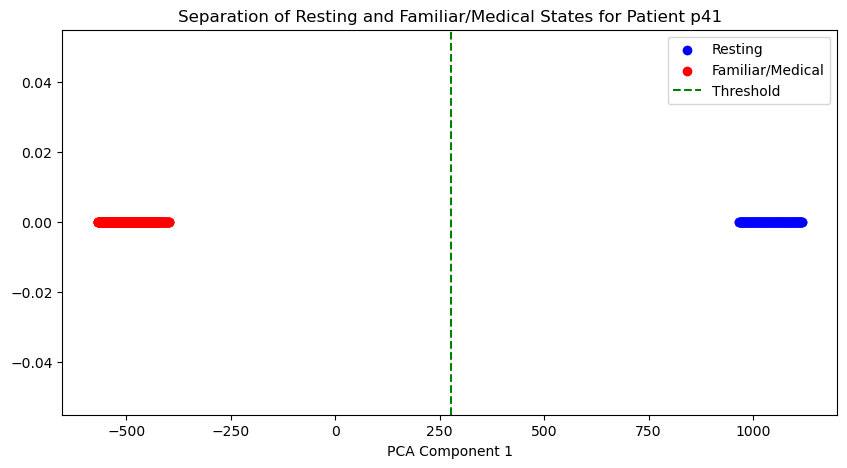

Fold Confusion Matrix for Patient p42:
[[38  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        61

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99

Fold Confusion Matrix for Patient p42:
[[38  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        61

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99

Fold Confusion Matrix for Patient p42:
[[23  0]
 [ 0 76]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

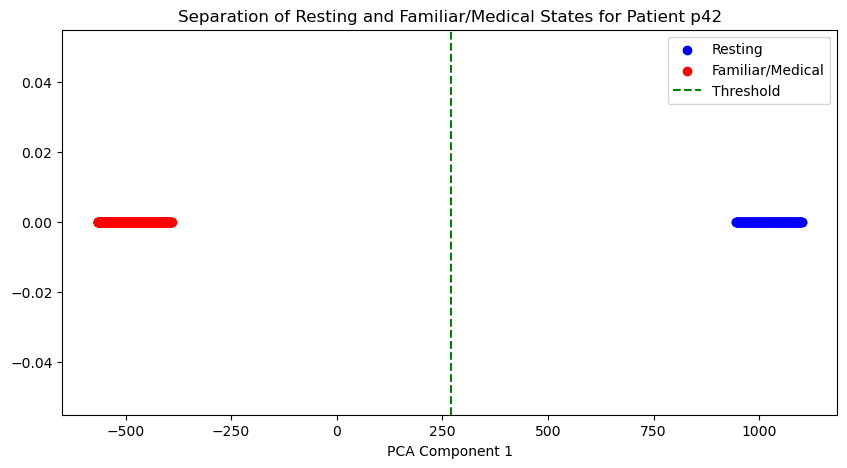

Fold Confusion Matrix for Patient p43:
[[36  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        62

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98

Fold Confusion Matrix for Patient p43:
[[37  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        61

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98

Fold Confusion Matrix for Patient p43:
[[25  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

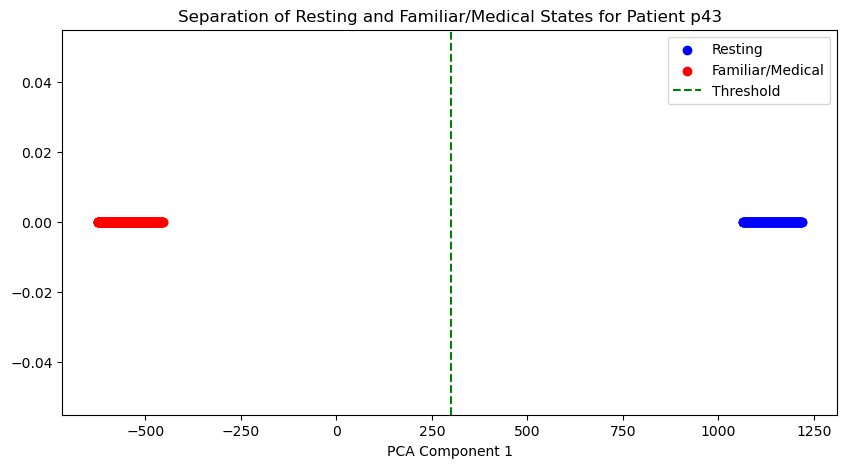

Fold Confusion Matrix for Patient p44:
[[35  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        62

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p44:
[[34  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        63

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p44:
[[25  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

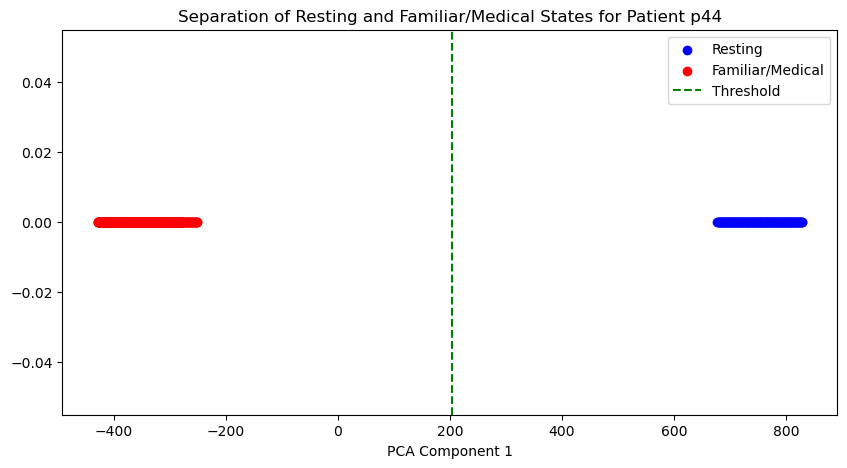

Fold Confusion Matrix for Patient p45:
[[31  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        61

    accuracy                           1.00        92
   macro avg       1.00      1.00      1.00        92
weighted avg       1.00      1.00      1.00        92

Fold Confusion Matrix for Patient p45:
[[32  0]
 [ 0 60]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        60

    accuracy                           1.00        92
   macro avg       1.00      1.00      1.00        92
weighted avg       1.00      1.00      1.00        92

Fold Confusion Matrix for Patient p45:
[[25  0]
 [ 0 67]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

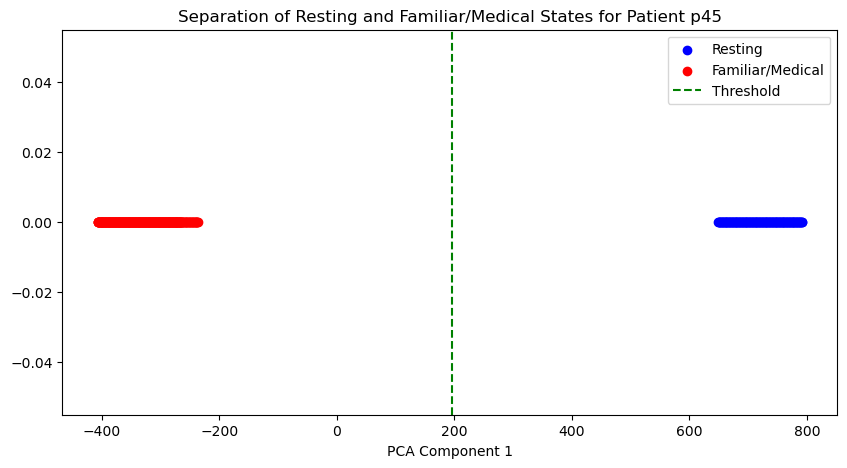

Fold Confusion Matrix for Patient p46:
[[36  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        63

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99

Fold Confusion Matrix for Patient p46:
[[38  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        61

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99

Fold Confusion Matrix for Patient p46:
[[26  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

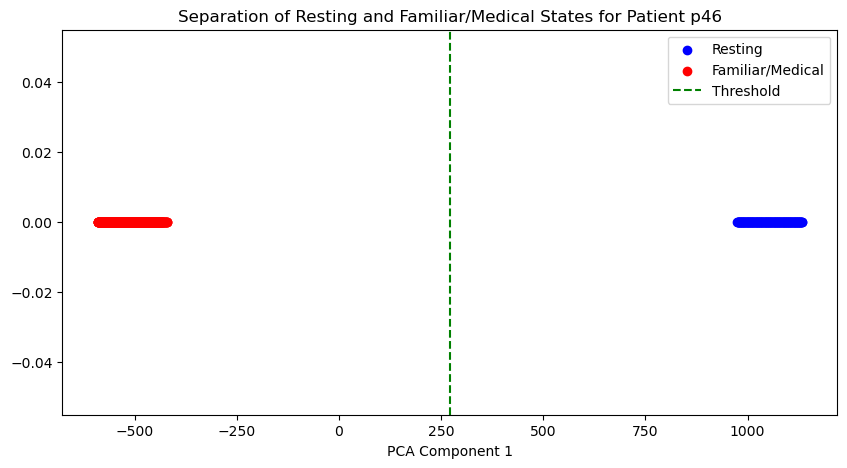

Fold Confusion Matrix for Patient p47:
[[37  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        63

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Fold Confusion Matrix for Patient p47:
[[36  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        63

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99

Fold Confusion Matrix for Patient p47:
[[23  0]
 [ 0 76]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

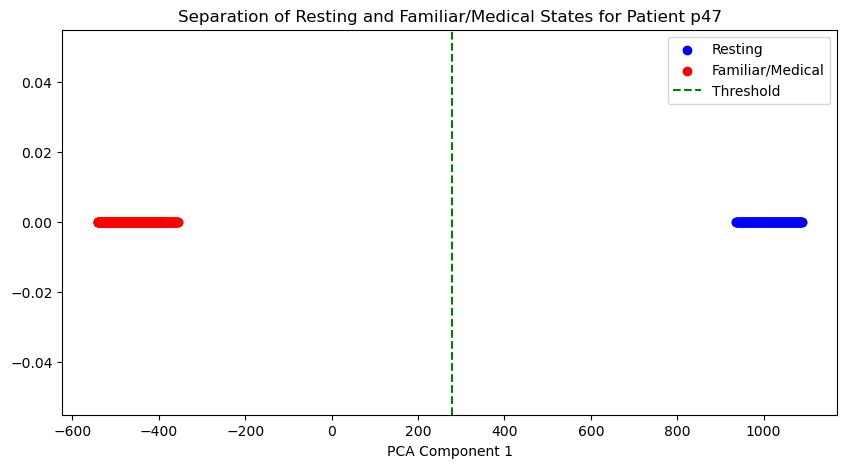

Fold Confusion Matrix for Patient p48:
[[31  0]
 [ 0 65]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        65

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Fold Confusion Matrix for Patient p48:
[[38  0]
 [ 0 58]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        58

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Fold Confusion Matrix for Patient p48:
[[24  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

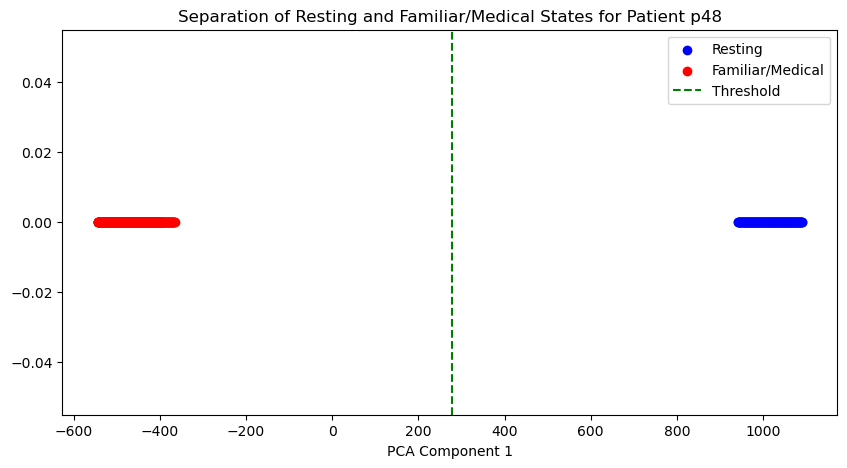

Fold Confusion Matrix for Patient p49:
[[34  0]
 [ 0 56]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        56

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90

Fold Confusion Matrix for Patient p49:
[[27  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        62

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89

Fold Confusion Matrix for Patient p49:
[[23  0]
 [ 0 66]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

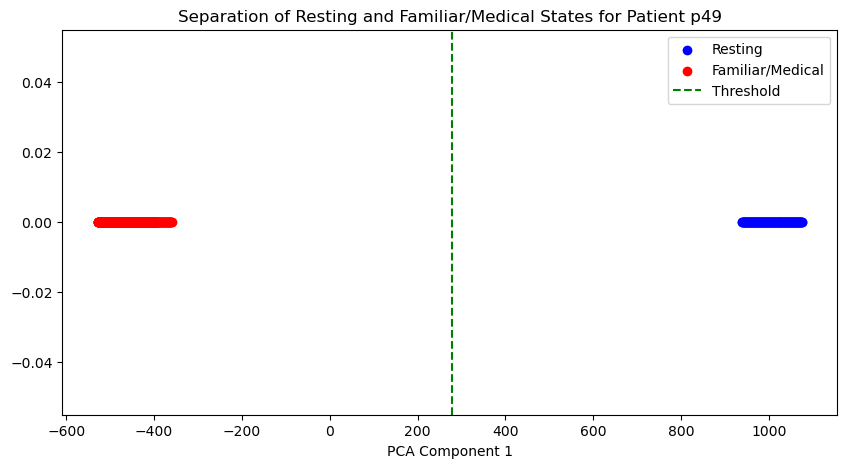

Fold Confusion Matrix for Patient p4:
[[38  0]
 [ 0 68]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        68

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106

Fold Confusion Matrix for Patient p4:
[[37  0]
 [ 0 69]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        69

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106

Fold Confusion Matrix for Patient p4:
[[28  0]
 [ 0 77]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00   

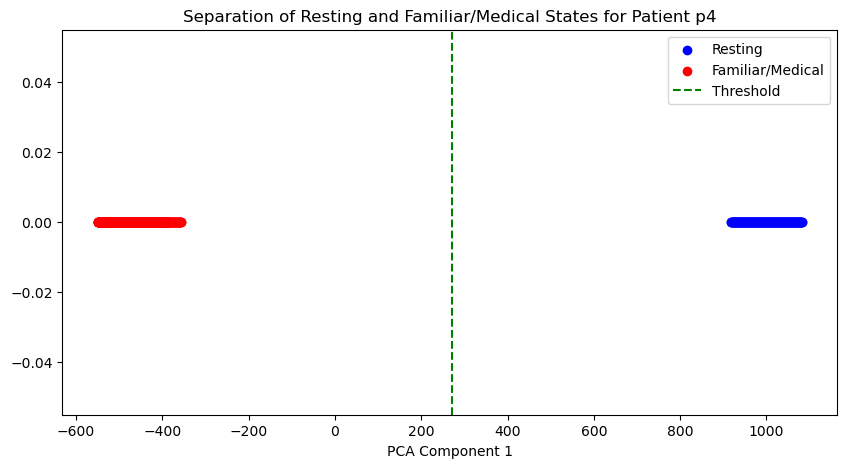

Fold Confusion Matrix for Patient p50:
[[33  0]
 [ 0 65]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        65

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98

Fold Confusion Matrix for Patient p50:
[[37  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        61

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98

Fold Confusion Matrix for Patient p50:
[[25  0]
 [ 0 73]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

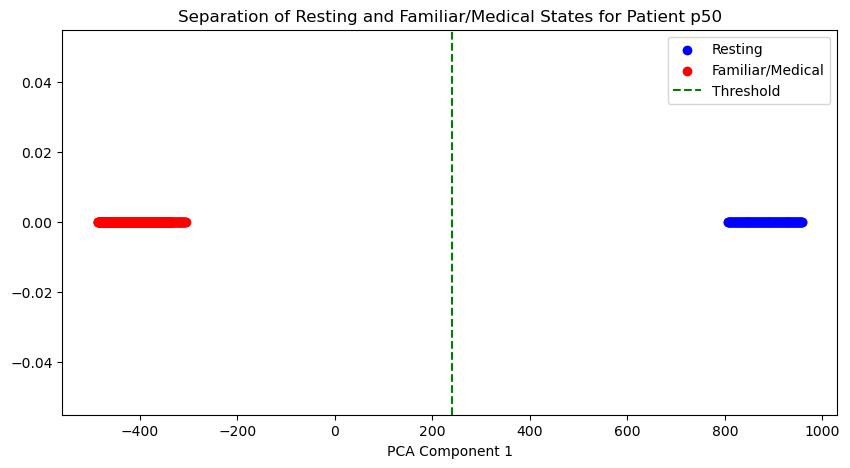

Fold Confusion Matrix for Patient p51:
[[37  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        63

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Fold Confusion Matrix for Patient p51:
[[36  0]
 [ 0 64]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        64

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Fold Confusion Matrix for Patient p51:
[[23  0]
 [ 0 77]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

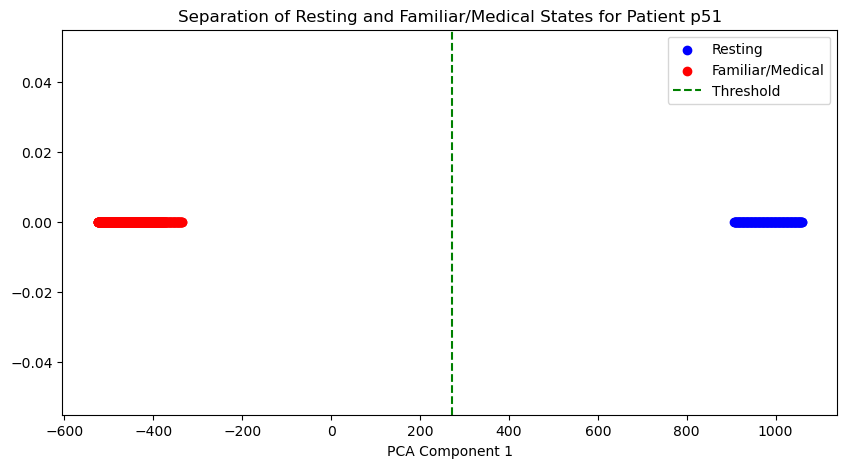

Fold Confusion Matrix for Patient p52:
[[36  0]
 [ 0 67]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        67

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Fold Confusion Matrix for Patient p52:
[[36  0]
 [ 0 67]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        67

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Fold Confusion Matrix for Patient p52:
[[29  0]
 [ 0 74]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

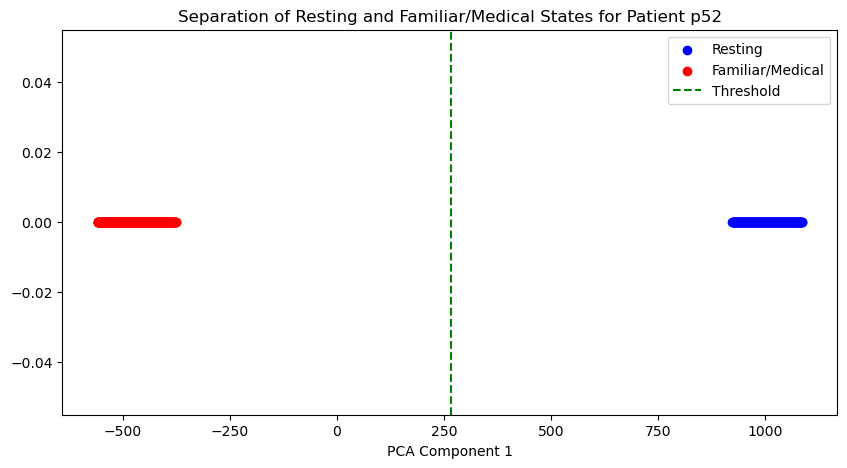

Fold Confusion Matrix for Patient p53:
[[31  0]
 [ 0 65]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        65

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Fold Confusion Matrix for Patient p53:
[[35  0]
 [ 0 60]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        60

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

Fold Confusion Matrix for Patient p53:
[[28  0]
 [ 0 67]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

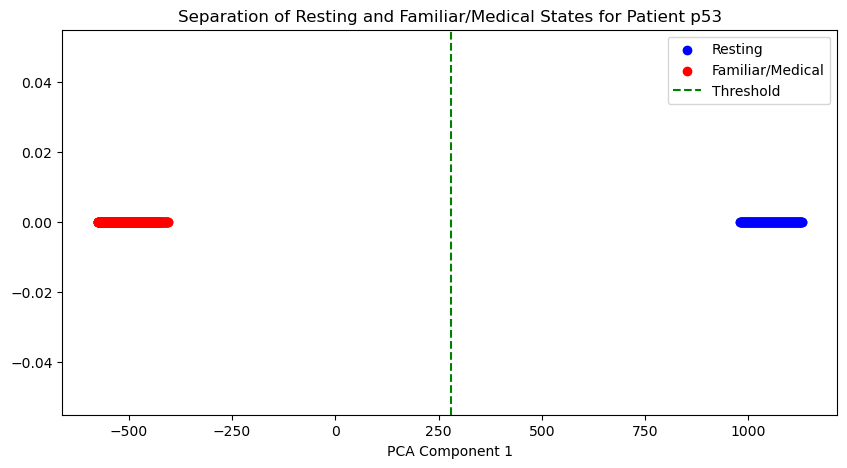

Fold Confusion Matrix for Patient p54:
[[32  0]
 [ 0 64]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        64

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Fold Confusion Matrix for Patient p54:
[[39  0]
 [ 0 57]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        57

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Fold Confusion Matrix for Patient p54:
[[25  0]
 [ 0 71]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

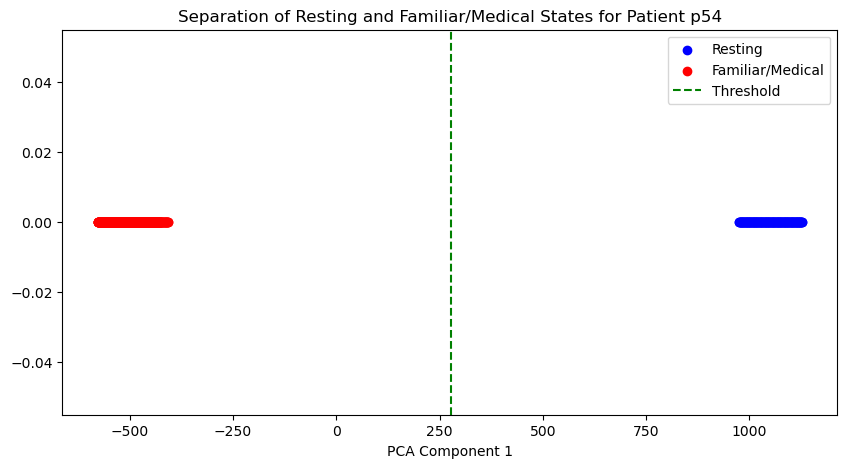

Fold Confusion Matrix for Patient p56:
[[33  0]
 [ 0 68]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        68

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101

Fold Confusion Matrix for Patient p56:
[[37  0]
 [ 0 64]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        64

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101

Fold Confusion Matrix for Patient p56:
[[23  0]
 [ 0 78]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

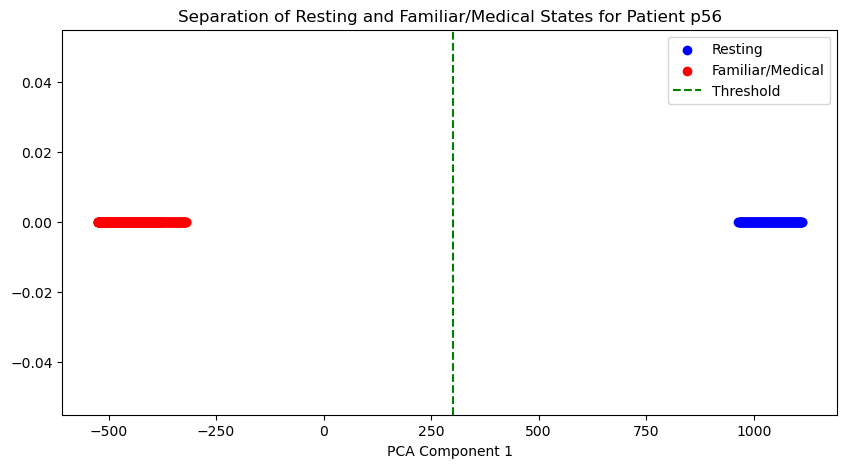

Fold Confusion Matrix for Patient p57:
[[36  0]
 [ 0 67]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        67

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103

Fold Confusion Matrix for Patient p57:
[[35  0]
 [ 0 67]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        67

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102

Fold Confusion Matrix for Patient p57:
[[29  0]
 [ 0 73]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

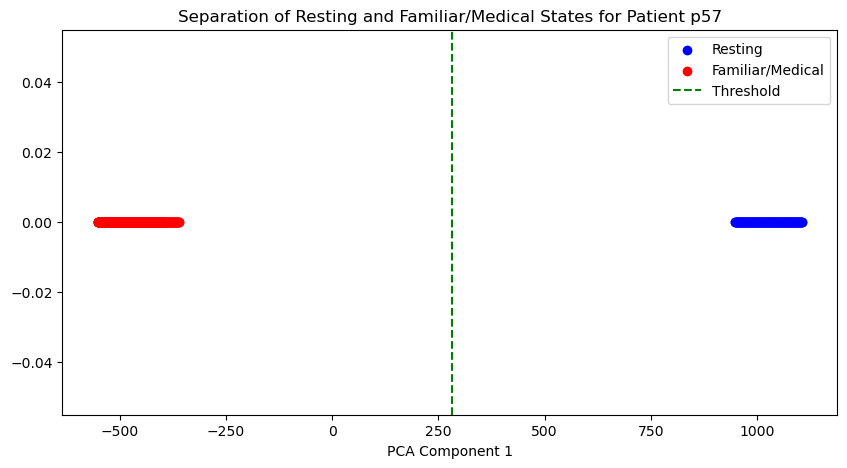

Fold Confusion Matrix for Patient p58:
[[31  0]
 [ 0 65]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        65

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Fold Confusion Matrix for Patient p58:
[[35  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        61

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Fold Confusion Matrix for Patient p58:
[[27  0]
 [ 0 68]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

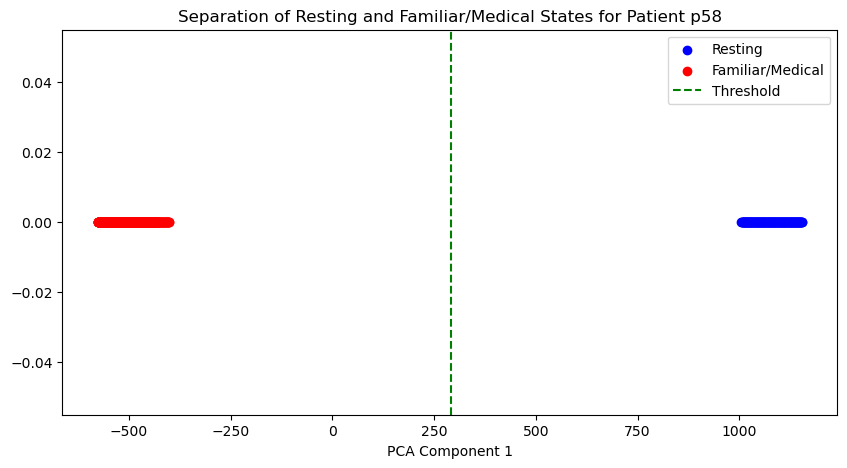

Fold Confusion Matrix for Patient p59:
[[32  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        62

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94

Fold Confusion Matrix for Patient p59:
[[32  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        62

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94

Fold Confusion Matrix for Patient p59:
[[28  0]
 [ 0 66]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

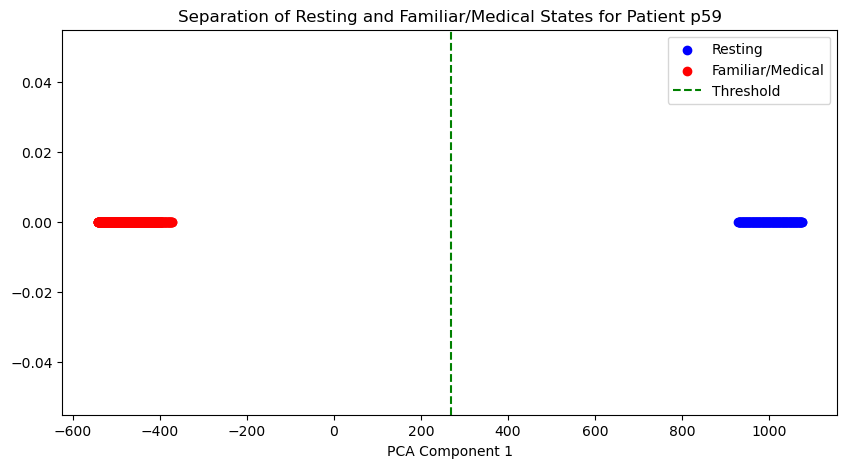

Fold Confusion Matrix for Patient p5:
[[35  0]
 [ 0 66]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        66

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101

Fold Confusion Matrix for Patient p5:
[[40  0]
 [ 0 60]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        60

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Fold Confusion Matrix for Patient p5:
[[26  0]
 [ 0 74]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00   

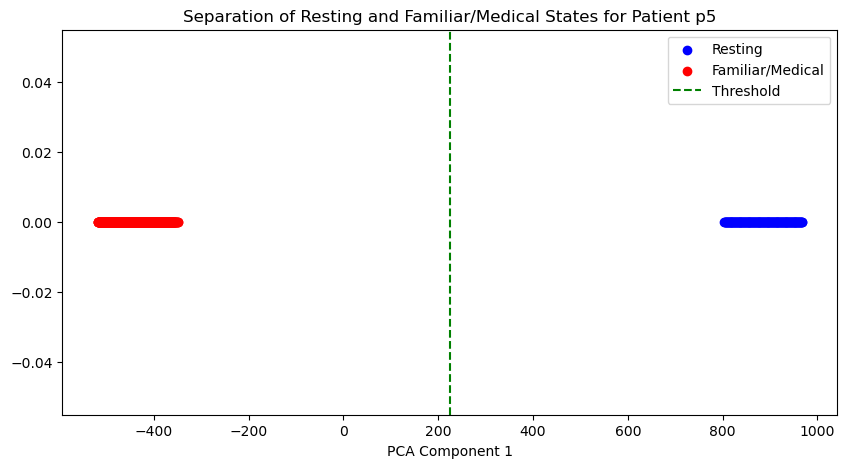

Fold Confusion Matrix for Patient p60:
[[35  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        63

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98

Fold Confusion Matrix for Patient p60:
[[38  0]
 [ 0 59]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        59

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p60:
[[25  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

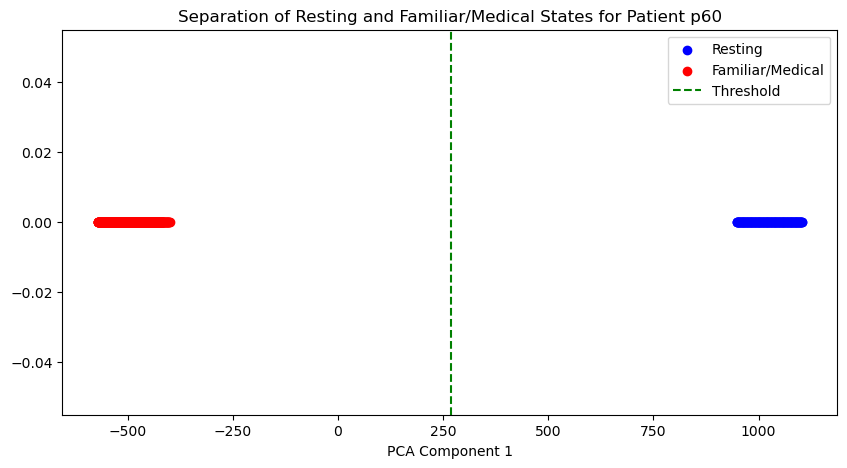

Fold Confusion Matrix for Patient p61:
[[36  0]
 [ 0 59]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        59

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

Fold Confusion Matrix for Patient p61:
[[33  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        62

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

Fold Confusion Matrix for Patient p61:
[[28  0]
 [ 0 67]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

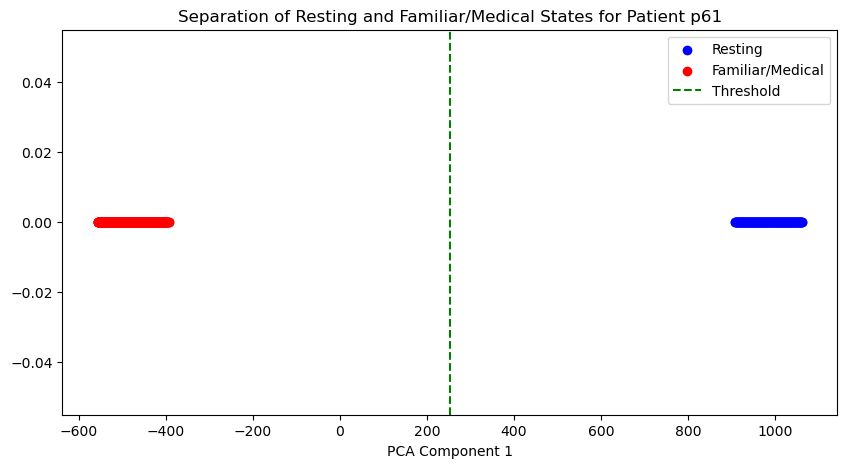

Fold Confusion Matrix for Patient p62:
[[35  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        62

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p62:
[[35  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        62

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p62:
[[25  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

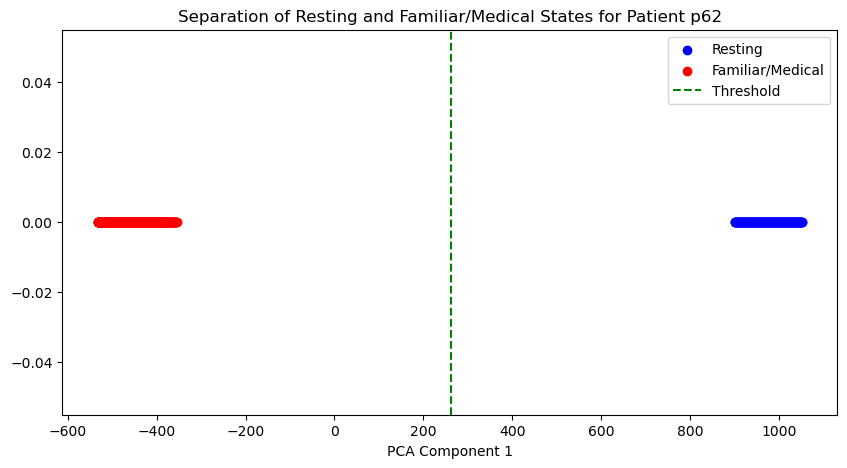

Fold Confusion Matrix for Patient p63:
[[35  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        62

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p63:
[[34  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        63

    accuracy                           1.00        97
   macro avg       1.00      1.00      1.00        97
weighted avg       1.00      1.00      1.00        97

Fold Confusion Matrix for Patient p63:
[[25  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

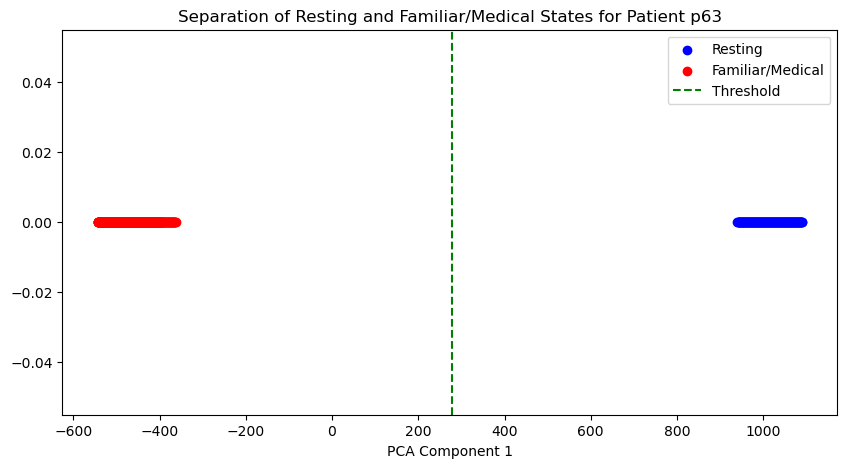

Fold Confusion Matrix for Patient p65:
[[33  0]
 [ 0 66]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        66

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99

Fold Confusion Matrix for Patient p65:
[[36  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        63

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99

Fold Confusion Matrix for Patient p65:
[[24  0]
 [ 0 74]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

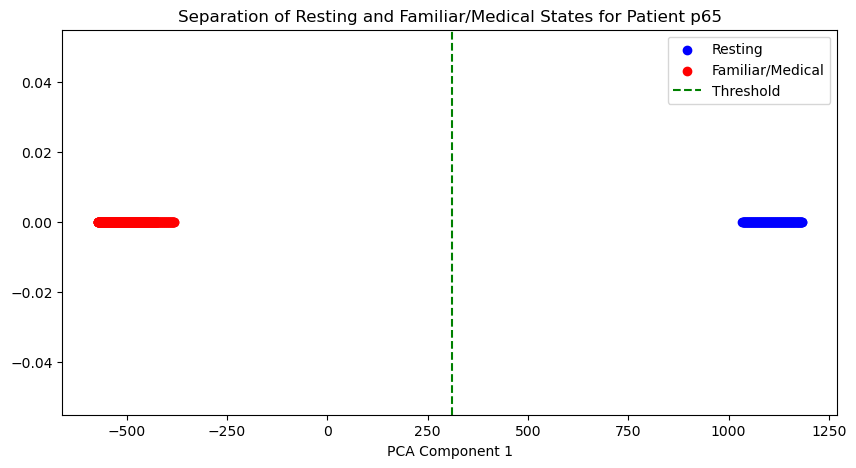

Fold Confusion Matrix for Patient p66:
[[32  0]
 [ 0 64]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        64

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Fold Confusion Matrix for Patient p66:
[[36  0]
 [ 0 60]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        60

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Fold Confusion Matrix for Patient p66:
[[27  0]
 [ 0 69]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

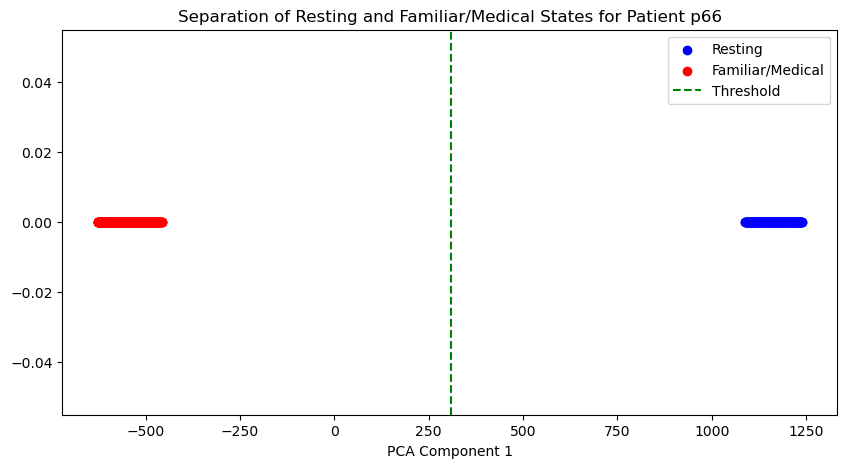

Fold Confusion Matrix for Patient p67:
[[33  0]
 [ 0 67]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        67

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Fold Confusion Matrix for Patient p67:
[[37  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        63

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Fold Confusion Matrix for Patient p67:
[[24  0]
 [ 0 76]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

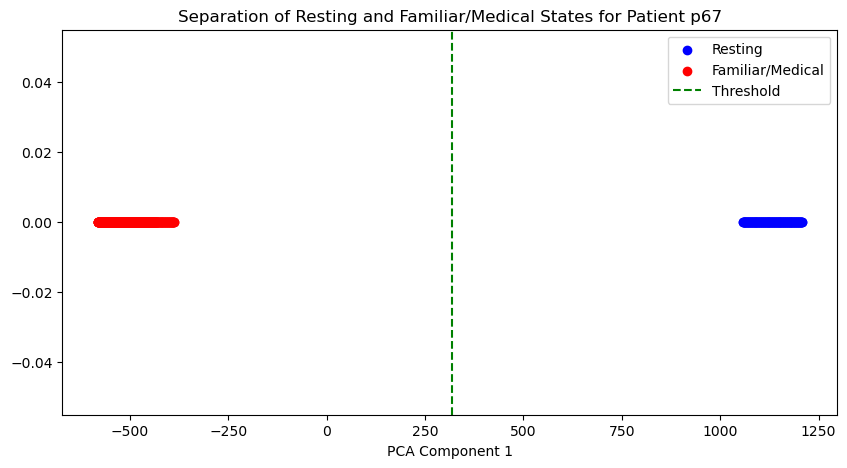

Fold Confusion Matrix for Patient p68:
[[33  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        61

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94

Fold Confusion Matrix for Patient p68:
[[32  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        62

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94

Fold Confusion Matrix for Patient p68:
[[28  0]
 [ 0 66]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

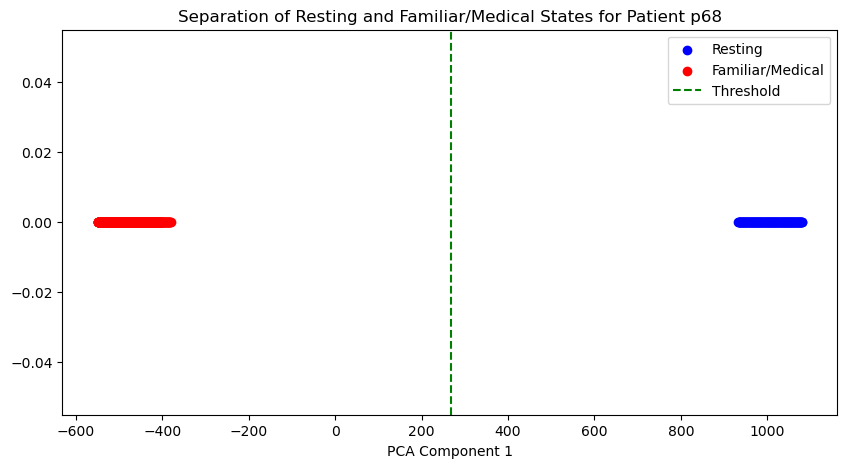

Fold Confusion Matrix for Patient p69:
[[34  0]
 [ 0 60]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        60

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94

Fold Confusion Matrix for Patient p69:
[[31  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        63

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94

Fold Confusion Matrix for Patient p69:
[[28  0]
 [ 0 65]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

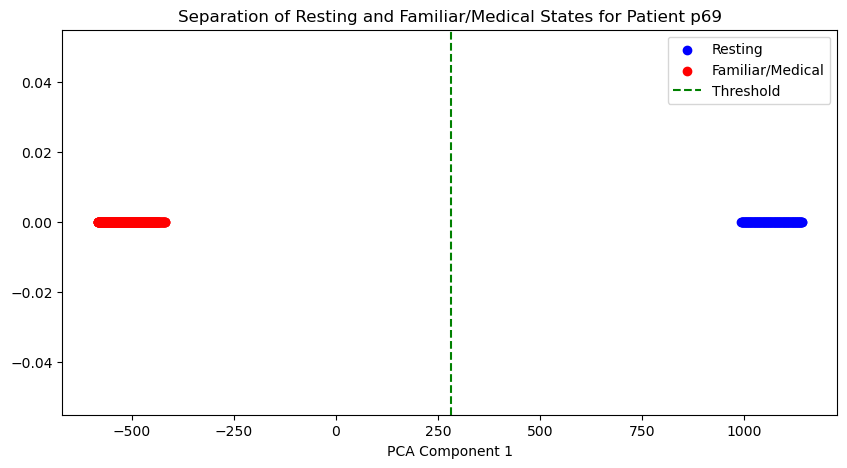

Fold Confusion Matrix for Patient p6:
[[35  0]
 [ 0 67]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        67

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102

Fold Confusion Matrix for Patient p6:
[[40  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        61

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101

Fold Confusion Matrix for Patient p6:
[[25  0]
 [ 0 76]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00   

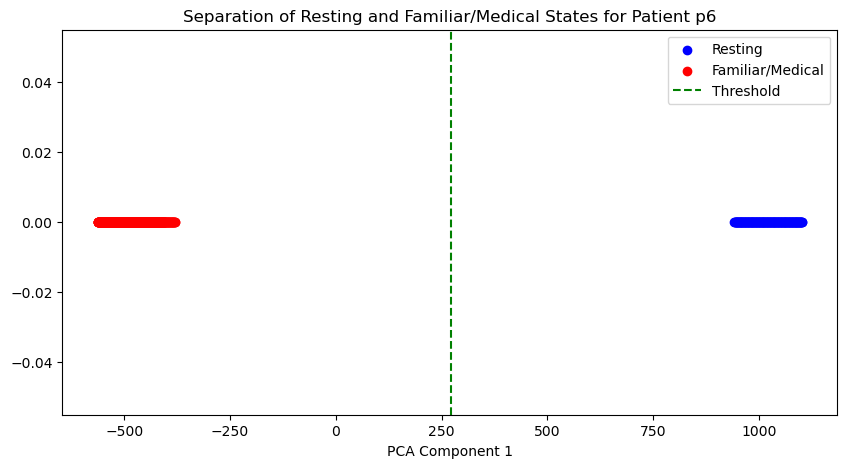

Fold Confusion Matrix for Patient p71:
[[34  0]
 [ 0 68]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        68

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102

Fold Confusion Matrix for Patient p71:
[[37  0]
 [ 0 65]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        65

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102

Fold Confusion Matrix for Patient p71:
[[27  0]
 [ 0 75]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

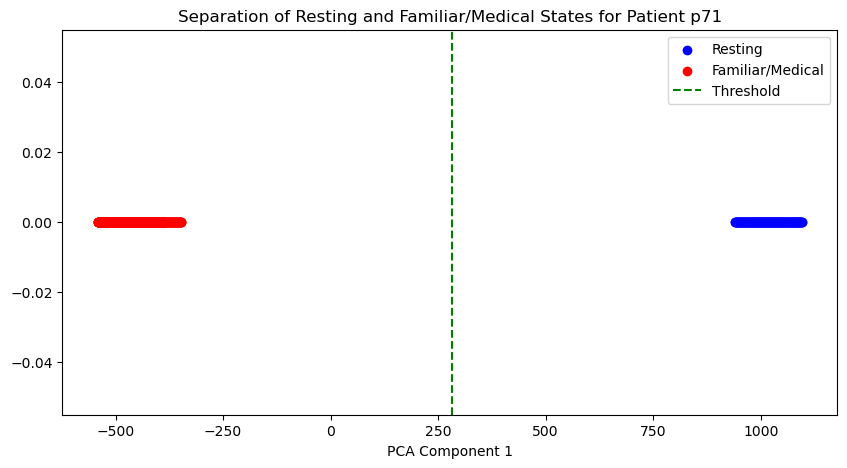

Fold Confusion Matrix for Patient p72:
[[31  0]
 [ 0 61]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        61

    accuracy                           1.00        92
   macro avg       1.00      1.00      1.00        92
weighted avg       1.00      1.00      1.00        92

Fold Confusion Matrix for Patient p72:
[[34  0]
 [ 0 58]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        58

    accuracy                           1.00        92
   macro avg       1.00      1.00      1.00        92
weighted avg       1.00      1.00      1.00        92

Fold Confusion Matrix for Patient p72:
[[28  0]
 [ 0 64]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

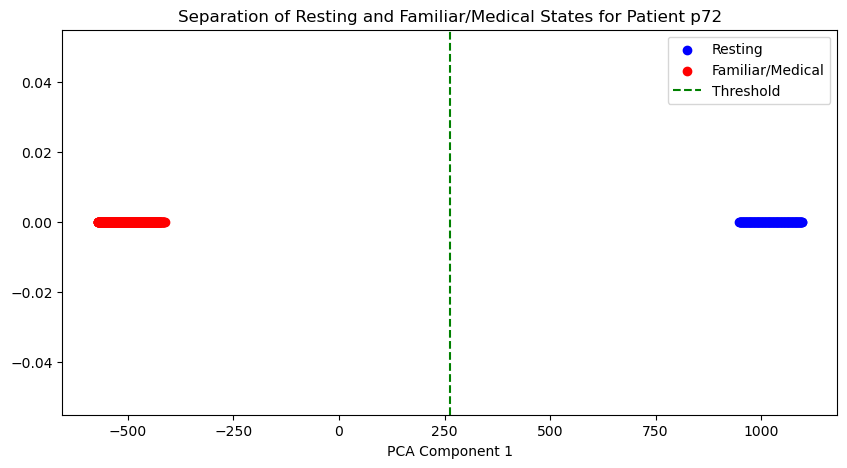

Fold Confusion Matrix for Patient p73:
[[35  0]
 [ 0 60]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        60

    accuracy                           1.00        95
   macro avg       1.00      1.00      1.00        95
weighted avg       1.00      1.00      1.00        95

Fold Confusion Matrix for Patient p73:
[[32  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        62

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94

Fold Confusion Matrix for Patient p73:
[[29  0]
 [ 0 65]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

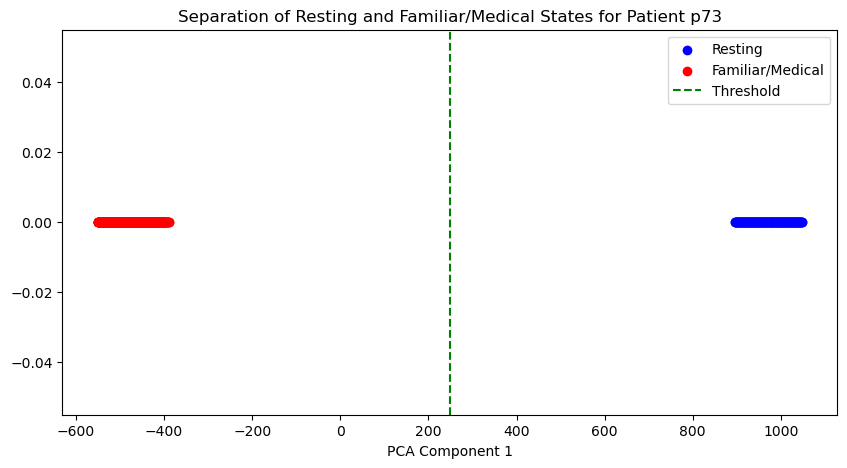

Fold Confusion Matrix for Patient p74:
[[45  0]
 [ 0 95]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        95

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140

Fold Confusion Matrix for Patient p74:
[[ 40   0]
 [  0 100]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00       100

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140

Fold Confusion Matrix for Patient p74:
[[ 37   0]
 [  0 103]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00  

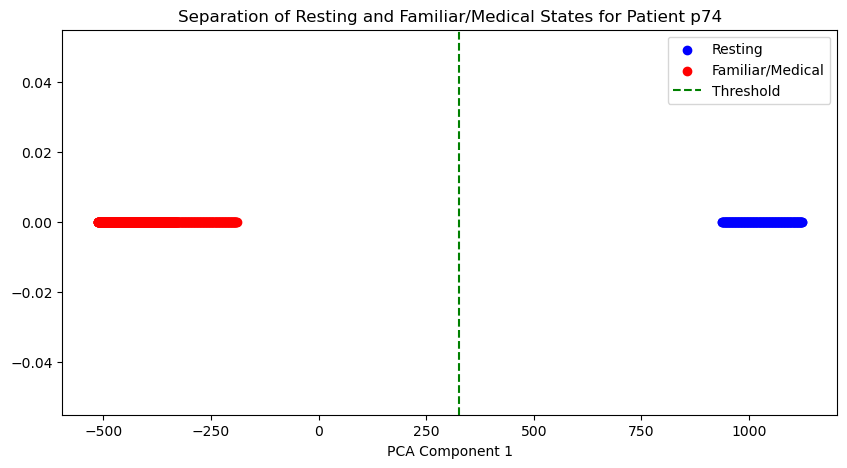

Fold Confusion Matrix for Patient p75:
[[37  0]
 [ 0 89]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        89

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126

Fold Confusion Matrix for Patient p75:
[[39  0]
 [ 0 86]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        86

    accuracy                           1.00       125
   macro avg       1.00      1.00      1.00       125
weighted avg       1.00      1.00      1.00       125

Fold Confusion Matrix for Patient p75:
[[36  0]
 [ 0 89]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

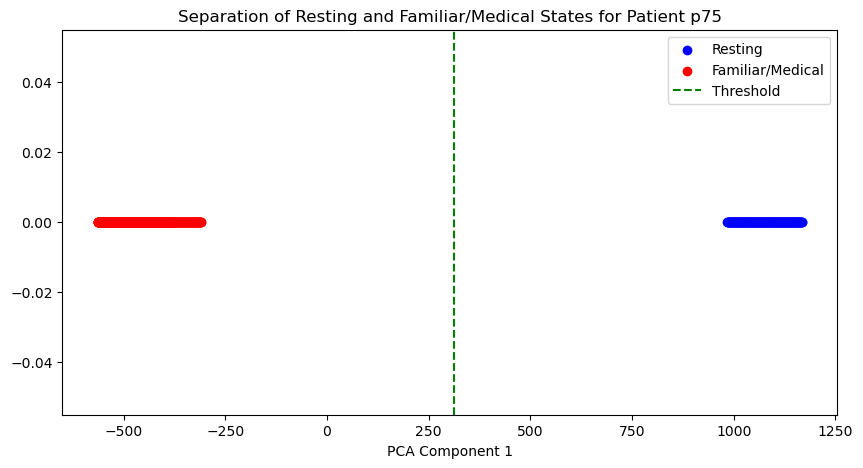

Fold Confusion Matrix for Patient p76:
[[38  0]
 [ 0 82]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        82

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

Fold Confusion Matrix for Patient p76:
[[34  0]
 [ 0 85]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        85

    accuracy                           1.00       119
   macro avg       1.00      1.00      1.00       119
weighted avg       1.00      1.00      1.00       119

Fold Confusion Matrix for Patient p76:
[[38  0]
 [ 0 81]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

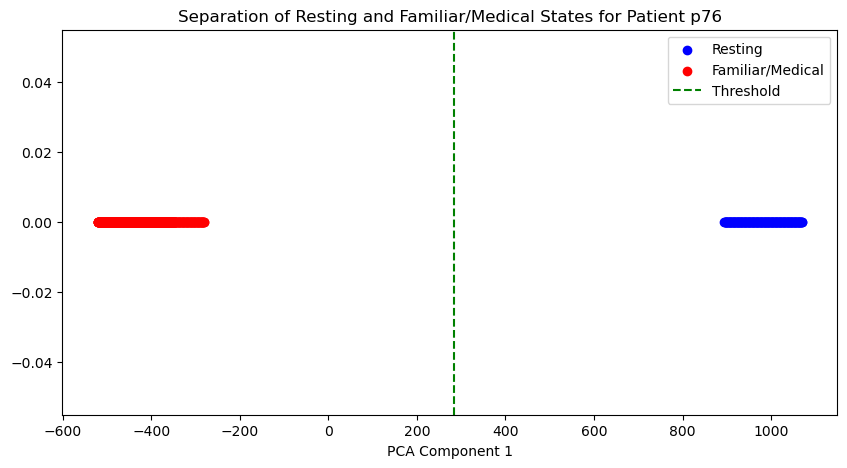

Fold Confusion Matrix for Patient p77:
[[37  0]
 [ 0 84]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        84

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121

Fold Confusion Matrix for Patient p77:
[[34  0]
 [ 0 87]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        87

    accuracy                           1.00       121
   macro avg       1.00      1.00      1.00       121
weighted avg       1.00      1.00      1.00       121

Fold Confusion Matrix for Patient p77:
[[35  0]
 [ 0 86]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

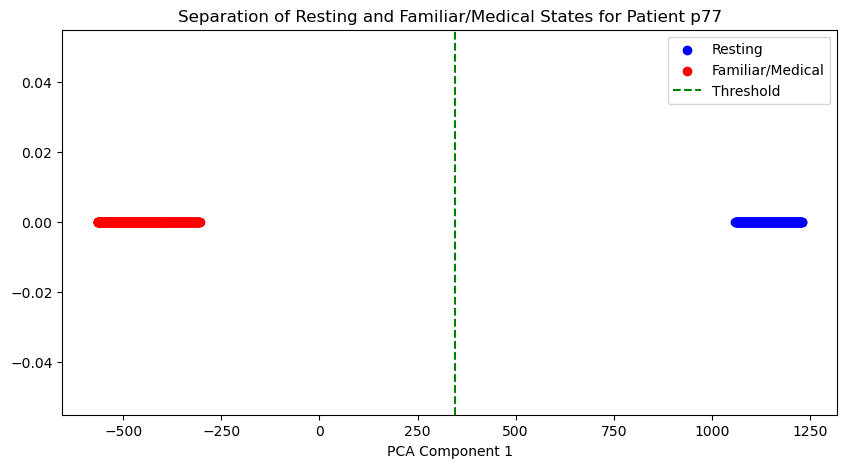

Fold Confusion Matrix for Patient p78:
[[34  0]
 [ 0 67]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        67

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101

Fold Confusion Matrix for Patient p78:
[[41  0]
 [ 0 60]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        60

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101

Fold Confusion Matrix for Patient p78:
[[25  0]
 [ 0 76]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

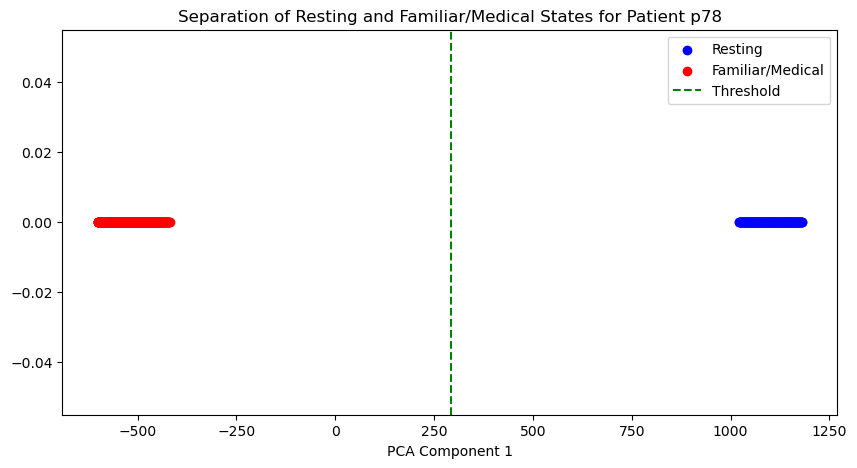

Fold Confusion Matrix for Patient p79:
[[36  0]
 [ 0 86]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        86

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122

Fold Confusion Matrix for Patient p79:
[[36  0]
 [ 0 86]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        86

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122

Fold Confusion Matrix for Patient p79:
[[34  0]
 [ 0 88]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

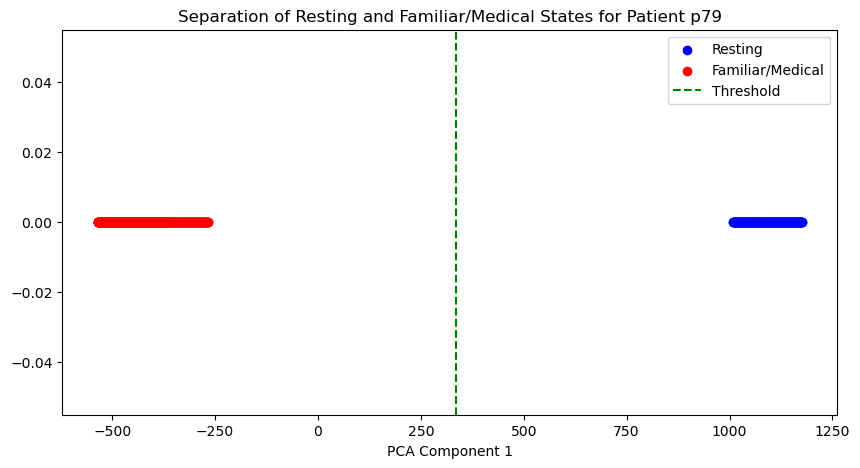

Fold Confusion Matrix for Patient p7:
[[35  0]
 [ 0 65]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        65

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Fold Confusion Matrix for Patient p7:
[[40  0]
 [ 0 60]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00        60

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Fold Confusion Matrix for Patient p7:
[[25  0]
 [ 0 75]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00   

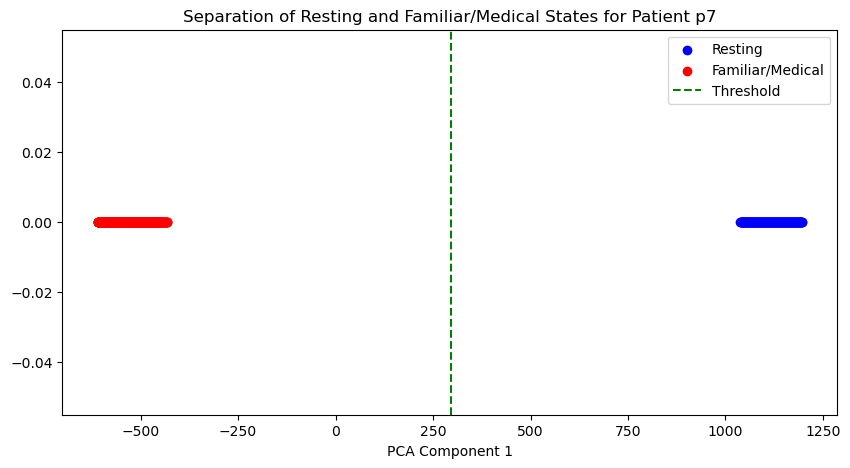

Fold Confusion Matrix for Patient p80:
[[38  0]
 [ 0 78]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00        78

    accuracy                           1.00       116
   macro avg       1.00      1.00      1.00       116
weighted avg       1.00      1.00      1.00       116

Fold Confusion Matrix for Patient p80:
[[34  0]
 [ 0 82]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        82

    accuracy                           1.00       116
   macro avg       1.00      1.00      1.00       116
weighted avg       1.00      1.00      1.00       116

Fold Confusion Matrix for Patient p80:
[[35  0]
 [ 0 81]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00

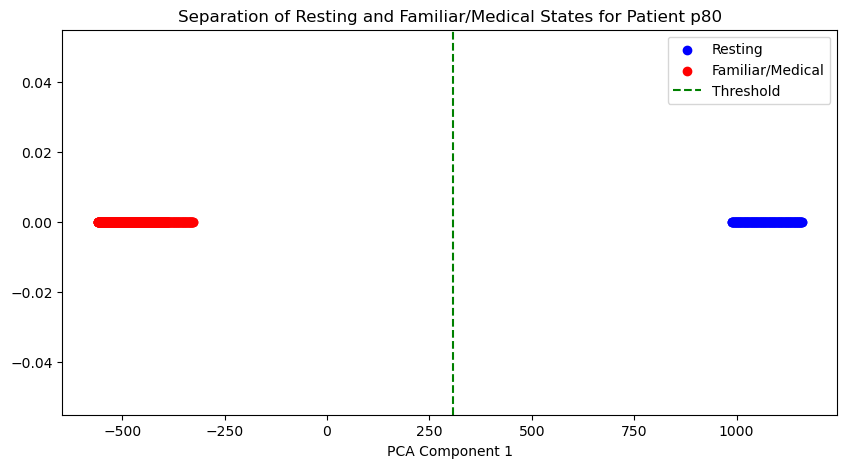

Fold Confusion Matrix for Patient p8:
[[37  0]
 [ 0 57]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        57

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94

Fold Confusion Matrix for Patient p8:
[[32  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        62

    accuracy                           1.00        94
   macro avg       1.00      1.00      1.00        94
weighted avg       1.00      1.00      1.00        94

Fold Confusion Matrix for Patient p8:
[[29  0]
 [ 0 65]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00   

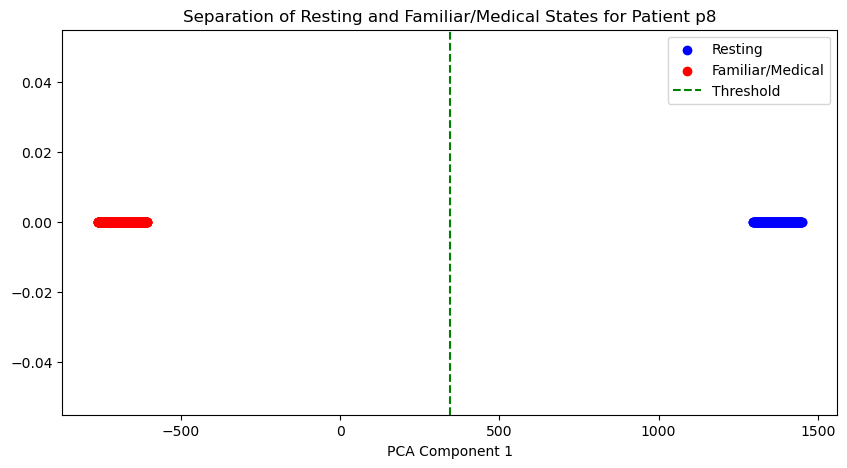

Fold Confusion Matrix for Patient p9:
[[35  0]
 [ 0 63]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        35
           1       1.00      1.00      1.00        63

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98

Fold Confusion Matrix for Patient p9:
[[36  0]
 [ 0 62]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        62

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98

Fold Confusion Matrix for Patient p9:
[[26  0]
 [ 0 72]]
Fold Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00   

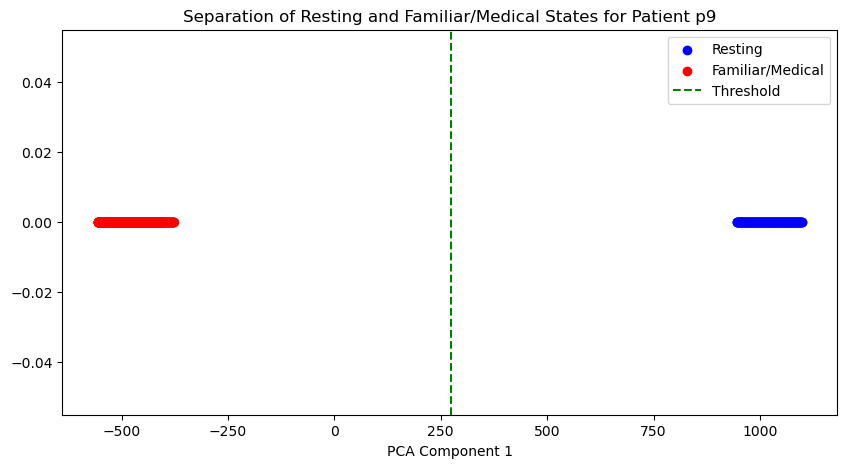

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def classification_with_cross_validation(patient_data, patients, n_components_pca=1, n_splits=5, save_to_pdf=False, output_pdf_path='combined_patient_plots_final.pdf'):
    feature_names = ['PSD Delta', 'PSD Theta', 'PSD Alpha', 'PSD Beta', 'PSD Gamma', 'PSD SE', 'PSD MSF', 'PSD Sef90', 'PSD Sef95', 'PE', 'wSMI', 'Kolmogorov', 'Freq_Slope mean', 'Freq_Slope std']
    
    if save_to_pdf:
        pdf = PdfPages(output_pdf_path)
    
    for patient in patients:
        data = patient_data[patient].copy()

        # Define the events as resting or combined familiar/medical
        labels = data['Event'].apply(lambda x: 1 if x in [1, 2] else 0).values  # Familiar/Medical as 1, Resting as 0
        data_for_pca = data.drop(columns=['Event']).values

        # Cross-validation setup
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_accuracies = []

        for train_index, test_index in kf.split(data_for_pca):
            X_train, X_test = data_for_pca[train_index], data_for_pca[test_index]
            y_train, y_test = labels[train_index], labels[test_index]
            
            # Apply PCA on the training data and transform both train and test sets
            pca = PCA(n_components=n_components_pca)
            X_train_pca = pca.fit_transform(X_train)
            X_test_pca = pca.transform(X_test)

            # Determine the threshold based on training data
            threshold = (X_train_pca[y_train == 0].mean() + X_train_pca[y_train == 1].mean()) / 2

            # Predict using the threshold
            y_pred = (X_test_pca[:, 0] < threshold).astype(int)

            # Evaluate accuracy for this fold
            fold_accuracy = accuracy_score(y_test, y_pred)
            fold_accuracies.append(fold_accuracy)

            # Optionally, print confusion matrix and classification report for each fold
            print(f"Fold Confusion Matrix for Patient {patient}:")
            print(confusion_matrix(y_test, y_pred))
            print("Fold Classification Report:")
            print(classification_report(y_test, y_pred))

        # Calculate and print the average accuracy across all folds
        average_accuracy = np.mean(fold_accuracies)
        print(f"Average Cross-Validation Accuracy for Patient {patient}: {average_accuracy}")

        # Plot PCA component 1 with threshold
        fig, ax = plt.subplots(figsize=(10, 5))
        X_pca_full = pca.fit_transform(data_for_pca)
        threshold = (X_pca_full[labels == 0].mean() + X_pca_full[labels == 1].mean()) / 2
        ax.scatter(X_pca_full[labels == 0, 0], np.zeros_like(X_pca_full[labels == 0, 0]), color='blue', label='Resting')
        ax.scatter(X_pca_full[labels == 1, 0], np.zeros_like(X_pca_full[labels == 1, 0]), color='red', label='Familiar/Medical')
        ax.axvline(x=threshold, color='green', linestyle='--', label='Threshold')
        ax.set_title(f"Separation of Resting and Familiar/Medical States for Patient {patient}")
        ax.set_xlabel('PCA Component 1')
        ax.legend()

        if save_to_pdf:
            pdf.savefig(fig)
            plt.close(fig)
        else:
            plt.show()

    if save_to_pdf:
        pdf.close()

# Example usage for all patients
patients = patient_data.keys()
classification_with_cross_validation(patient_data, patients, n_components_pca=1, n_splits=5)
